# Mood-based Song Recommendation System

## Introduction

In this project, I aim to create a song recommendation system based on the user's emotion detected through their prompt, as well as the main topic of the prompt.

## 0. Import Modules

In [1]:
## Import modules

# Key standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# To count an iterable object
from collections import Counter

# For Wordcloud visualisation
from wordcloud import WordCloud   

# For language detection library
from langdetect import detect, LangDetectException, DetectorFactory

# Functionalities from Natural Language Tokeniser: NLTK
import nltk 
from nltk.corpus import stopwords # A pre-defined list of stopwords
from nltk.tokenize import word_tokenize, WhitespaceTokenizer # Tokenisers to use
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from word2number import w2n

# For data cleaning and NLP
import re
import string

## Modelling from gensim for topic modelling
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models, similarities
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# To calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Pipeline to use Hugging Face transformer model
from transformers import pipeline, AutoTokenizer

## 1. Data Exploration

### 1.1 Load the Dataset

For this project, I will be using an existing dataset on Kaggle which contains a variety of features including song metadata, audio features and lyrics. Source: [Kaggle - 960K Spotify Songs With Lyrics data](https://www.kaggle.com/datasets/bwandowando/spotify-songs-with-attributes-and-lyrics). 

From this dataset, only the song title, artist title and lyrics will be used which do not use Spotify's API features e.g., audio features. This information can be gathered without it so it does not go against Spotify's TOS.

In [22]:
## Load the dataset into a dataframe
data = pd.read_csv("Data/songs_with_attributes_and_lyrics.csv")

In [20]:
## Display column names
data.columns

Index(['id', 'name', 'album_name', 'artists', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'lyrics'],
      dtype='object')

In [24]:
## Remove the unnecessary columns
cols_to_keep = ['name', 'album_name', 'artists', 'lyrics']
lyrics = data[cols_to_keep]

In [26]:
## Display overview
lyrics.info() # 955,320 records

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955320 entries, 0 to 955319
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   name        955309 non-null  object
 1   album_name  385557 non-null  object
 2   artists     955318 non-null  object
 3   lyrics      955307 non-null  object
dtypes: object(4)
memory usage: 29.2+ MB


Here, I will subset this randomly due to the large dataset meaning that processing the data is too slow.

A potential limitation of this is that the subset might not have a variety of genres/emotions needed.

In [30]:
## Take a random subset of 100,000 songs
subset = lyrics.sample(n=100000, random_state=0)

In [34]:
## Display first few records
subset.head()

,name,album_name,artists,lyrics
930896,Быстрый,NaN,GSPD,В нашем селе из доступных развлечений\n Есть т...
183560,Deixa Queimar - Ao Vivo,NaN,Alessandro Vilas Boas,Ouvi o meu Senhor bater na porta\n E o meu cor...
493311,Marioneta,NaN,['Control Machete'],"Agazapo un lamento, me salgo del\n cuento, cue..."
571324,Old Macdonald Had a Farm,NaN,['The Kiboomers'],What animals do you see on a farm?\n What soun...
377135,INSTADRAMA,INSTADRAMA,['LOBODA'],Вот и мы расстаёмся с тобой\n Закрывая на серд...


### 1.2 Data Cleaning

These are the data cleaning steps needing to be taken:
- Remove records with null values
- Remove duplicated songs
- Remove non-english songs
- Clean up `artists` columns

In [173]:
## Remove records with key missing information(large dataset anyway)
lyrics_no_null = subset.dropna(subset=['name', 'artists', 'lyrics' ])

In [175]:
lyrics_no_null.shape # 99,997 records

(99997, 4)

In [177]:
## Remove duplicated records

# Drop duplicate names and artists
print(lyrics_no_null.duplicated(subset=['name', 'artists']).sum()) # 1,124 records
lyrics_no_null_dup = lyrics_no_null.drop_duplicates(subset=['name', 'artists'])

# Drop duplicates in lyrics
print(lyrics_no_null_dup.duplicated(subset=['lyrics']).sum()) # 1,019
lyrics_no_null_dup = lyrics_no_null_dup.drop_duplicates(subset=['lyrics'])

1124
1019


In [179]:
## Overview
lyrics_no_null_dup.info() # 97,854 records

<class 'pandas.core.frame.DataFrame'>
Index: 97854 entries, 930896 to 159133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        97854 non-null  object
 1   album_name  39160 non-null  object
 2   artists     97854 non-null  object
 3   lyrics      97854 non-null  object
dtypes: object(4)
memory usage: 3.7+ MB


In [181]:
## Display first few rows
lyrics_no_null_dup.head(10)

,name,album_name,artists,lyrics
930896,Быстрый,NaN,GSPD,В нашем селе из доступных развлечений\n Есть т...
183560,Deixa Queimar - Ao Vivo,NaN,Alessandro Vilas Boas,Ouvi o meu Senhor bater na porta\n E o meu cor...
493311,Marioneta,NaN,['Control Machete'],"Agazapo un lamento, me salgo del\n cuento, cue..."
571324,Old Macdonald Had a Farm,NaN,['The Kiboomers'],What animals do you see on a farm?\n What soun...
377135,INSTADRAMA,INSTADRAMA,['LOBODA'],Вот и мы расстаёмся с тобой\n Закрывая на серд...
443735,Learn To Love,To See You,"['Harry Connick, Jr.']",Lovers are dreamers and I've been walking in m...
657543,Run Around - Original Uncensored Version,Jefferson Airplane Takes Off,['Jefferson Airplane'],"One time, run around,\n Don't look and for me ..."
417698,Kanave Nee Naan,Kannum Kannum Kollaiyadithaal,Sooraj Santhosh,கனவே நீ நான் விழிக்கவில்லை\n கலைவாய் என்றே நின...
837572,Uh-Oh,Funny Farm,['King Kong'],What a day to be driving in Nevada\n What a da...
184330,Deliver the Suffering,A Manifesto for Domination,['Halcyon Way'],The rage like a ten ton weight\n Crushing down...


In [183]:
## Reset the index
lyrics_no_null_dup = lyrics_no_null_dup.reset_index(drop = True)

In [187]:
lyrics_no_null_dup.head()

,name,album_name,artists,lyrics
0,Быстрый,NaN,GSPD,В нашем селе из доступных развлечений\n Есть т...
1,Deixa Queimar - Ao Vivo,NaN,Alessandro Vilas Boas,Ouvi o meu Senhor bater na porta\n E o meu cor...
2,Marioneta,NaN,['Control Machete'],"Agazapo un lamento, me salgo del\n cuento, cue..."
3,Old Macdonald Had a Farm,NaN,['The Kiboomers'],What animals do you see on a farm?\n What soun...
4,INSTADRAMA,INSTADRAMA,['LOBODA'],Вот и мы расстаёмся с тобой\n Закрывая на серд...


In [189]:
## Observe the artists column
lyrics_no_null_dup['artists'][20:40]

20                                    ['lovelytheband']
21                                        Austin Mahone
22    ['Alceu Valença', 'Elba Ramalho', 'Geraldo Aze...
23                                        The Dictators
24                                        ['Big Stuff']
25                                     ['Barrio Pobre']
26                                     ['The Gap Band']
27                                      ['Jack Harlow']
28                                        Justin Quiles
29                          ['Queens of the Stone Age']
30                                        ['Afflicted']
31                                 Companhia do Calypso
32                                               Jungle
33                                 ['Sasha Alex Sloan']
34                                              OUTRAGE
35                                  Mors Principium Est
36                                   ['Little Brother']
37                                       ['Quasa

In [191]:
## Create a copy
lyrics_cleaned = lyrics_no_null_dup.copy()

In [193]:
## Clean the artists column into a string

def clean_artist_name(artist):
    # Remove square brackets [ and ]
    no_brackets = re.sub(r'[\[\]]', '', artist)
    
    # Split by both the comma and semicolon (with/without spaces)
    split_artists = re.split(r'[;,]\s*', no_brackets) # Create a list of each artist for that song
    
    # For each artist in the list, remove single quotes from the start and end of their name
    cleaned_artists = [name.strip("'") for name in split_artists]
    
    # Join the cleaned artist names into a single string
    return ', '.join(cleaned_artists)

# Apply the cleaning function to the 'artists' column
lyrics_cleaned['artists'] = lyrics_cleaned['artists'].apply(clean_artist_name)

In [205]:
## Observe the difference
lyrics_cleaned.head(10)

,name,album_name,artists,lyrics
0,Быстрый,NaN,GSPD,В нашем селе из доступных развлечений\n Есть т...
1,Deixa Queimar - Ao Vivo,NaN,Alessandro Vilas Boas,Ouvi o meu Senhor bater na porta\n E o meu cor...
2,Marioneta,NaN,Control Machete,"Agazapo un lamento, me salgo del\n cuento, cue..."
3,Old Macdonald Had a Farm,NaN,The Kiboomers,What animals do you see on a farm?\n What soun...
4,INSTADRAMA,INSTADRAMA,LOBODA,Вот и мы расстаёмся с тобой\n Закрывая на серд...
5,Learn To Love,To See You,"Harry Connick, Jr.",Lovers are dreamers and I've been walking in m...
6,Run Around - Original Uncensored Version,Jefferson Airplane Takes Off,Jefferson Airplane,"One time, run around,\n Don't look and for me ..."
7,Kanave Nee Naan,Kannum Kannum Kollaiyadithaal,Sooraj Santhosh,கனவே நீ நான் விழிக்கவில்லை\n கலைவாய் என்றே நின...
8,Uh-Oh,Funny Farm,King Kong,What a day to be driving in Nevada\n What a da...
9,Deliver the Suffering,A Manifesto for Domination,Halcyon Way,The rage like a ten ton weight\n Crushing down...


In [207]:
## Remove non-english songs using a language detection library

# Set the seed so the result is consistent each run (non-deterministic algorithm so can change for too short or ambiguous text)
DetectorFactory.seed = 0

In [209]:
## Examples of detection using only first 100 characters of the lyrics

print(f"Lyrics: \n{lyrics_cleaned['lyrics'].loc[0][:100]}\n Language detected: {detect(lyrics_cleaned['lyrics'].loc[0][:100])}")
print(f"Lyrics: \n{lyrics_cleaned['lyrics'].loc[3][:100]}\n Language detected: {detect(lyrics_cleaned['lyrics'].loc[3][:100])}")

Lyrics: 
В нашем селе из доступных развлечений
 Есть только пиздилово и танцы под баян
 Пацаны из города объе
 Language detected: ru
Lyrics: 
What animals do you see on a farm?
 What sounds do they make?
 A cow, moo
 Moo
 Old MacDonald had a 
 Language detected: en


In [211]:
## Detect the language 

def detect_language(lyric):
    # Detect the language based on first 100 characters of lyrics
    try:
        return detect(lyric[:100])
    # Return NaN if there is any errors
    except LangDetectException:
        return np.nan
    except Exception as e:
        return np.nan

# Apply the function
lyrics_cleaned['language'] = lyrics_cleaned['lyrics'].apply(lambda x: detect_language(x))

In [213]:
## Display the first few rows
lyrics_cleaned.head(10)

,name,album_name,artists,lyrics,language
0,Быстрый,NaN,GSPD,В нашем селе из доступных развлечений\n Есть т...,ru
1,Deixa Queimar - Ao Vivo,NaN,Alessandro Vilas Boas,Ouvi o meu Senhor bater na porta\n E o meu cor...,pt
2,Marioneta,NaN,Control Machete,"Agazapo un lamento, me salgo del\n cuento, cue...",es
3,Old Macdonald Had a Farm,NaN,The Kiboomers,What animals do you see on a farm?\n What soun...,en
4,INSTADRAMA,INSTADRAMA,LOBODA,Вот и мы расстаёмся с тобой\n Закрывая на серд...,ru
5,Learn To Love,To See You,"Harry Connick, Jr.",Lovers are dreamers and I've been walking in m...,en
6,Run Around - Original Uncensored Version,Jefferson Airplane Takes Off,Jefferson Airplane,"One time, run around,\n Don't look and for me ...",en
7,Kanave Nee Naan,Kannum Kannum Kollaiyadithaal,Sooraj Santhosh,கனவே நீ நான் விழிக்கவில்லை\n கலைவாய் என்றே நின...,ta
8,Uh-Oh,Funny Farm,King Kong,What a day to be driving in Nevada\n What a da...,en
9,Deliver the Suffering,A Manifesto for Domination,Halcyon Way,The rage like a ten ton weight\n Crushing down...,en


In [215]:
## Remove non-english songs
lyrics_eng = lyrics_cleaned[lyrics_cleaned['language'] == 'en'].copy().reset_index(drop = True)

In [217]:
## How many records do we have left?
lyrics_eng.shape # 71,563 songs

(71563, 5)

In [219]:
## Display first few rows
lyrics_eng.head()

,name,album_name,artists,lyrics,language
0,Old Macdonald Had a Farm,NaN,The Kiboomers,What animals do you see on a farm?\n What soun...,en
1,Learn To Love,To See You,"Harry Connick, Jr.",Lovers are dreamers and I've been walking in m...,en
2,Run Around - Original Uncensored Version,Jefferson Airplane Takes Off,Jefferson Airplane,"One time, run around,\n Don't look and for me ...",en
3,Uh-Oh,Funny Farm,King Kong,What a day to be driving in Nevada\n What a da...,en
4,Deliver the Suffering,A Manifesto for Domination,Halcyon Way,The rage like a ten ton weight\n Crushing down...,en


In [221]:
## Export as a .csv file (as a checkpoint)
lyrics_eng.to_csv("Data\lyrics_eng.csv", index= False)

In [223]:
## How many different artists are there?
lyrics_eng['artists'].head()

0         The Kiboomers
1    Harry Connick, Jr.
2    Jefferson Airplane
3             King Kong
4           Halcyon Way
Name: artists, dtype: object

In [267]:
lyrics_eng['artists'].value_counts()

artists
Various Artists      339
Elvis Presley        145
Grateful Dead        127
Bob Dylan            122
Aretha Franklin      100
                    ... 
Sons Of Zion           1
Con Funk Shun          1
Lower Class Brats      1
Nü Sensae              1
Moons of Mars          1
Name: count, Length: 26564, dtype: int64

In [270]:
## How many different artists are there?

lyrics_eng.describe(include = 'all')

,name,album_name,artists,lyrics,language
count,71563,29459,71563,71563,71563
unique,61155,19452,26564,71563,1
top,Home,Greatest Hits,Various Artists,What animals do you see on a farm?\n What soun...,en
freq,31,121,339,1,71563


There are 26,564 unique artists, and 71,563 unique songs. 
Majority of artists fall under 'Various Artists' (339 songs).

NOTE: There still might be similar songs e.g., remix of the same song etc., In the future, additional steps can be taken to ensure there are no remix/variations of the same song. However, due to the time limitation of this project, I will be proceding with the dataset.

## 2. Emotion Detection

### 2.1 Choosing the BERT model to use

I will be using a **pre-trained BERT model**, which have been fine-tuned for text emotion detection, on the lyrics.

To pick the model to use, I will manually check the emotion detected for the first 10 lyrics for three potential models from [Hugging Face](https://huggingface.co/) - `j-hartmann/emotion-english-distilroberta-base`, `SamLowe/roberta-base-go_emotions` and `michellejieli/emotion_text_classifier`.

Here are details regarding each model:

|Model|Emotions|Notes|
|---------------|---|---|
|`j-hartmann`   |Anger, Disgust, Fear, Joy, Neutral, Sadness, Surprise|Trained on 6 datasets using texts from social media e.g., Twitter, student self-reports, and TV dialogues.|
|`michellejieli`|Anger, Disgust, Fear, Joy, Neutral, Sadness, Surprise|Fine-tuned version of `j-hartmann` using additional emotional lines from Friends (TV show).|
|`SamLowe`      |Admiration, Amusement, Anger, Annoyance, Approval, Caring, Confusion, Curiosity, Desire, Disappointment,  Disapproval, Disgust, Embarrassment, Excitement, Fear, Gratitude, Grief, Joy, Love, Nervousness, Optimism, Pride, Realization, Relief, Remorse, Sadness, Surprise, Neutral|Trained using the GoEmotions dataset of Reddit comments labeled for 27 emotion categories (and neutral). Ideal for multi-label classification.|

For all of these models, there is a main **limitation**. These models have not been trained on lyrics, but other text, which might affect their performance on lyrics. For future work, it would be benefical to train a model/fine-tune these BERT models on labelled lyrics data. However, due to the lack of labelled lyrics with emotion data and time-constraint of this project, I will be using an existing BERT model with no further tuning.

In [4]:
## Observe dataset

lyrics_df = pd.read_csv("Data\lyrics_eng.csv") # Load from the saved .csv
lyrics_df.head()

,name,album_name,artists,lyrics,language
0,Old Macdonald Had a Farm,NaN,The Kiboomers,What animals do you see on a farm?\n What soun...,en
1,Learn To Love,To See You,"Harry Connick, Jr.",Lovers are dreamers and I've been walking in m...,en
2,Run Around - Original Uncensored Version,Jefferson Airplane Takes Off,Jefferson Airplane,"One time, run around,\n Don't look and for me ...",en
3,Uh-Oh,Funny Farm,King Kong,What a day to be driving in Nevada\n What a da...,en
4,Deliver the Suffering,A Manifesto for Domination,Halcyon Way,The rage like a ten ton weight\n Crushing down...,en


In [6]:
## Average length of lyrics
# Most transformer models have a maximum of 512 tokens.

lyrics_df['lyrics_length'] = lyrics_df['lyrics'].apply(len)
print(lyrics_df['lyrics_length'].agg(['mean', 'min', 'max']))

mean     1408.42733
min        15.00000
max     32281.00000
Name: lyrics_length, dtype: float64


These models have a token limit of 512. Most lyrics are longer than the limit.

For the prpose of choosing the model, I will break the lyrics into chunks, predict the emotion of the chunk, and aggregate the most frequent emotion of all the chunks as the emotion of the song. This retains the overall emotion of the song.

In [8]:
## Use three different BERT models (fine-tuned for emotions)
hartmann = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None) # top_k = None means show all scores
michelle = pipeline("text-classification", model="michellejieli/emotion_text_classifier",  top_k=None) 
sam = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

In [289]:
## A function to split the lyrics into chunks (not real tokens used by the model)

def chunk_lyrics(lyric, chunk_size=425): # Each chunk will be 400 characters long. NOTE: The token size limit is 512 a token does not translate to words or characters. 
    # Split the lyrics into a list of chunks of length 500
    chunks = [lyric[i:(i+chunk_size)] for i in range(0, len(lyric), chunk_size)]

    # Join the characters back into words and sentences for each chunk
    return ["".join(chunk) for chunk in chunks]

All these models have their own pre-processing steps built-in the pipeline, so I will be doing minimal cleaning of the lyrics for this. Note: Through the testing, it was found that some simple cleaning helped with more accurate detection.

In [291]:
## Test the models on the first 10 lyrics

model_test = []

# Loop through the first 10 lyrics to test the emotion models
for lyric in lyrics_df['lyrics'][0:10]:
    # Create an empty dictionary
    current_lyric = {}

    # Basic, quick cleaning of the lyrics and add it to the dictionary
    lyric_clean = lyric.strip().replace('\n', '').lower().replace(' ♪', '')
    current_lyric['Lyrics'] = lyric_clean

    # Break the lyrics into chunks
    chunks = chunk_lyrics(lyric_clean)
    
    # Create an empty list for the predicted emotion of each chunk
    hartmann_result = []
    michelle_result = []
    sam_result = []
    
    # Loop through each chunk
    for chunk in chunks:
        # Predict and store the emotions for each chunk
        hartmann_result.append(hartmann(chunk)[0][0]['label']) # Highest probability emotion only
        michelle_result.append(michelle(chunk)[0][0]['label'])
        sam_result.append(sam(chunk)[0][0]['label'])

    # Select the most frequent emotion all the chunks for that lyric
    current_lyric['Hartmann'] = Counter(hartmann_result).most_common(1)[0][0] # Counts the occurence of each emotion and return the top emotion only (or top 2
    current_lyric['Michelle'] = Counter(michelle_result).most_common(1)[0][0]
    current_lyric['Sam'] = Counter(sam_result).most_common(1)[0][0]

    # Add the current lyric to the list
    model_test.append(current_lyric)

# Create a dataframe
model_test_df = pd.DataFrame(model_test)

# Display it
model_test_df

,Lyrics,Hartmann,Michelle,Sam
0,What animals do you see on a farm?\n What soun...,neutral,joy,neutral
1,Lovers are dreamers and I've been walking in m...,fear,joy,love
2,"One time, run around,\n Don't look and for me ...",sadness,anger,desire
3,What a day to be driving in Nevada\n What a da...,surprise,fear,neutral
4,The rage like a ten ton weight\n Crushing down...,sadness,sadness,sadness
5,So miserable\n ♪\n My funeral\n And I try to f...,sadness,sadness,sadness
6,I spy\n Something beginning with 'S'\n On cand...,fear,fear,fear
7,Through the mist of not so distant future year...,neutral,neutral,neutral
8,I already decided bitch that I don't need no s...,anger,anger,neutral
9,There's one way to whistle\n Whistle while you...,fear,neutral,love


In [199]:
## Display the lyrics for the first 10 songs

for lyric in lyrics_df['lyrics'][0:10]:
    print(lyric + '\n____________________________________\n')

What animals do you see on a farm?
 What sounds do they make?
 A cow, moo
 Moo
 Old MacDonald had a farm (hello), EE-I-EE-I-O
 And on his farm he had a cow, EE-I-EE-I-O
 With a moo-moo here and a moo-moo there
 Here a moo, there a moo, everywhere a moo-moo
 Old MacDonald had a farm, EE-I-EE-I-O
 A chicken, cluck-cluck
 Old MacDonald had a farm (hello), EE-I-EE-I-O
 And on his farm he had a chicken, EE-I-EE-I-O
 With a cluck-cluck here and a cluck-cluck there
 Here a cluck, there a cluck, everywhere a cluck-cluck
 Old MacDonald had a farm, EE-I-EE-I-O
 A pig, oink-oink
 Old MacDonald had a farm (hello), EE-I-EE-I-O
 And on his farm he had a pig, EE-I-EE-I-O
 With a oink-oink here and a oink-oink there
 Here a oink, there a oink, everywhere a oink-oink
 Old MacDonald had a farm, EE-I-EE-I-O
 A sheep, baa, baa
 Old MacDonald had a farm (hello), EE-I-EE-I-O
 And on his farm he had a sheep, EE-I-EE-I-O
 With a baa-baa here and a baa-baa there
 Here a baa, there a baa, everywhere a baa-baa
 

Here is my personal judgement of the emotion of each lyric:
- 0: Neutral
- 1: Joy/Love (Hartmann confused it for fear)
- 2: Heartbreak/Longing/Sadness/anger?
- 3: Surprise/slight fear/neutral
- 4: Anger (all said sadness)
- 5: Sadness
- 6: Fear
- 7: Anger? (all said neutral)
- 8: Anger?/annoyance
- 9: Neutral/possibly love

Based on this, I will be using the `michellejieli/emotion_text_classifier` model. This is because it gave the most similar emotions to my personal judgement. I have chosen not to use `SamLowe/roberta-base-go_emotions` despite it having a greater range of emotions (more specific) as due to the computational power of my laptop, it would take too long to use on my dataset.

### 2.2 Lyrics Emotion Detection

For each song, I will detect the key emotion using the chosen BERT model. However, due to the computational power of the model, I will sample my dataset again to 10,000 songs.

In [8]:
## Create a function to accurately chunk the lyrics into 512 tokens

# Use the tokeniser from the model itself
tokeniser = AutoTokenizer.from_pretrained("michellejieli/emotion_text_classifier")

def chunk_lyrics_by_token(lyric, max_tokens=512): # Set the maximum token limit
    # Use the tokeniser to turn the lyrics into tokens
    lyrics_tokenised = tokeniser(lyric, truncation=False) # Do not cut it short
    input_ids = lyrics_tokenised['input_ids'] # Each token has an ID

    # Calculate how many tokens will fit within the limit (accounting for special tokens)
    max_tokens -= tokeniser.num_special_tokens_to_add(pair=False)

    # Break the lyrics into chunks that fit within the token limit
    chunks = [input_ids[i:i + max_tokens] for i in range(0, len(input_ids), max_tokens)]
    
    # Decode the token chunks back into string text
    decoded_chunks = [tokeniser.decode(chunk, skip_special_tokens=True) for chunk in chunks]

    return decoded_chunks

In [52]:
## Create a function to detect emotions

# Load the model chosen with top_k=1 to get only the top emotion
michelle = pipeline(task="text-classification", model="michellejieli/emotion_text_classifier", top_k=1)

def detect_emotion(lyric):
    # Perform quick, basic cleaning on the lyrics
    lyric_clean = lyric.strip().replace('\n', '').lower().replace(' ♪', '')

    # Break the lyrics into chunks
    chunks = chunk_lyrics_by_token(lyric_clean)

    # Create an empty list for the predicted emotion of each chunk
    all_emotions = []

    # Loop through each chunk
    for chunk in chunks:
        # Predict and store the emotions for each chunk
        try:
            prediction = michelle(chunk)
            all_emotions.append(prediction[0][0]['label'])  # Take the top label
        except RuntimeError: # Occurs if the length of the chunk exceeds limit for any reason
            return np.NaN # Return NaN for that lyric

    # Select the most frequent emotion all the chunks for that song
    return Counter(all_emotions).most_common(1)[0][0] # Only the label

In [14]:
## Take a random subset of 10,000 songs
lyrics_ss_df = lyrics_df.sample(n=10000, random_state=15)

In [16]:
## Reset the index
lyrics_ss_df = lyrics_ss_df.reset_index(drop = True)

In [18]:
## Observe the first few rows
lyrics_ss_df.head()

,name,album_name,artists,lyrics,language,lyrics_length
0,They Want War,NaN,U.D.O.,They are young and they're kids\n And believe ...,en,1285
1,Cry,Asphodel,The Machine In The Garden,I cry for the things you know\n the things tha...,en,285
2,Know Better (feat. Mister Blonde),NaN,JayKode,We stay up till we see the sun\n But I can nev...,en,1223
3,Baltimore,NaN,The Drifters,Beat-up little seagull\n On a marble stair\n T...,en,786
4,This Goodbye,Porcelain Heart,Beth Crowley,My world caught fire\n You're the one who lit ...,en,1347


In [20]:
## Create a column to store the emotions
lyrics_ss_df['emotion'] = np.nan

In [56]:
## NOTE: This code was generated by ChatGPT to speed up the process of applying detect_emotion on the dataframe

import concurrent.futures

def parallel_batch_processing(df, batch_size=500, max_workers=8):
    num_batches = len(df) // batch_size + 1  # Calculate number of batches

    # Split the DataFrame into batches
    batches = [df.iloc[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]

    # Function to process a batch and return the result
    def process_batch(batch):
        batch['emotion'] = batch['lyrics'].apply(detect_emotion)
        return batch

    # Use a ThreadPoolExecutor to process batches in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(process_batch, batches))

    # Concatenate the processed batches back together
    return pd.concat(results, ignore_index=True)

# Apply parallel batch processing
lyrics_ss_df = parallel_batch_processing(lyrics_ss_df, batch_size=500, max_workers=8)

C:\Users\isabe\AppData\Local\Temp\ipykernel_11688\2586408163.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['emotion'] = batch['lyrics'].apply(detect_emotion)


In [60]:
## Observe the first few rows
lyrics_ss_df.head()

,name,album_name,artists,lyrics,language,lyrics_length,emotion
0,They Want War,NaN,U.D.O.,They are young and they're kids\n And believe ...,en,1285,disgust
1,Cry,Asphodel,The Machine In The Garden,I cry for the things you know\n the things tha...,en,285,sadness
2,Know Better (feat. Mister Blonde),NaN,JayKode,We stay up till we see the sun\n But I can nev...,en,1223,fear
3,Baltimore,NaN,The Drifters,Beat-up little seagull\n On a marble stair\n T...,en,786,sadness
4,This Goodbye,Porcelain Heart,Beth Crowley,My world caught fire\n You're the one who lit ...,en,1347,sadness


In [64]:
## Check for any null values for the emotion

lyrics_ss_df['emotion'].isnull().sum()

0

In [73]:
## Save the file (no need to re-run code)

lyrics_ss_df.to_csv("Data\lyrics_with_emotions.csv", index = False)

### 2.3 Explore the Songs by Emotion

In [3]:
## Observe the first few records
lyrics_emotions = pd.read_csv("Data/lyrics_with_emotions.csv")
lyrics_emotions.head(5)

,name,album_name,artists,lyrics,language,lyrics_length,emotion
0,They Want War,NaN,U.D.O.,They are young and they're kids\n And believe ...,en,1285,disgust
1,Cry,Asphodel,The Machine In The Garden,I cry for the things you know\n the things tha...,en,285,sadness
2,Know Better (feat. Mister Blonde),NaN,JayKode,We stay up till we see the sun\n But I can nev...,en,1223,fear
3,Baltimore,NaN,The Drifters,Beat-up little seagull\n On a marble stair\n T...,en,786,sadness
4,This Goodbye,Porcelain Heart,Beth Crowley,My world caught fire\n You're the one who lit ...,en,1347,sadness


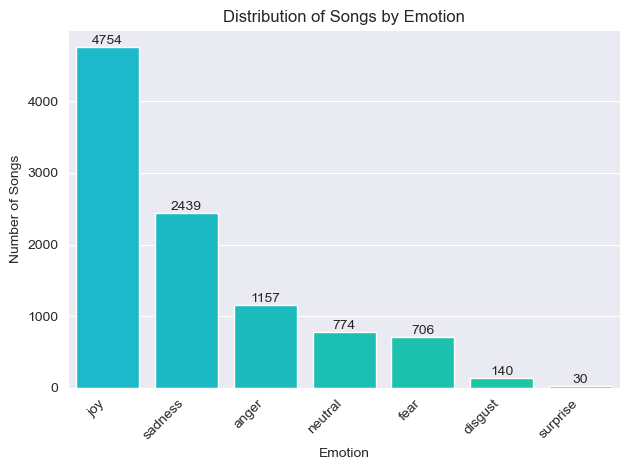

In [99]:
## Plot the distribution of songs by emotion

# Create a dataframe with the count of each emotion
emotion_count = pd.DataFrame(lyrics_emotions['emotion'].value_counts())

# Set a style
sns.set_style("darkgrid")

# Set a custom colour palette
custom_palette = sns.color_palette("blend:#00D1E9,#00e4ae", n_colors= 7)

# Plot the barplot
ax = sns.barplot(data = emotion_count,
            x = 'emotion',
            y = 'count',
            palette = custom_palette,
            hue = 'emotion'
           )

# Adjust the x-axis labels
plt.xticks(rotation= 45, # rotating labels
           horizontalalignment = 'right' , # aligning them with the bars
           fontweight = 'light',
           fontsize = 'medium' # setting the fonts
          )

# Add a title and labels
plt.title('Distribution of Songs by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Number of Songs')

# Add the song count as annotations on the bar
for i in ax.containers:
    ax.bar_label(i,)

# Save the image
plt.savefig('emotion_song_distribution.png', 
            dpi=300,              # High resolution
            bbox_inches='tight',  # Removes extra whitespace
            pad_inches=0.1)       # Adds small padding

# Display the plot
plt.tight_layout()
plt.show()

The majority of the detected songs fall under the 'joy' category followed by 'sadness'. This is in line with my hypothesis as most songs tend to be happy or sad from personal experience. This would also be the most common situations people would want to listen to songs too, and works for the purpose of mood-based song recommendation. 

In [137]:
## Average lyrics length by emotion

lyrics_emotions.groupby('emotion')['lyrics_length'].mean().sort_values(ascending=False)

emotion
anger       1625.669836
joy         1462.736012
fear        1403.949008
neutral     1296.215762
sadness     1275.823698
surprise    1227.766667
disgust     1191.707143
Name: lyrics_length, dtype: float64

There is not too much difference, but anger songs tend to have more lyrics than others. This could be due to rap genre songs tend to having more angry lyrics and rap songs are lyrics-heavy.

In [207]:
## How many unique artists are there per emotion? 

lyrics_emotions.groupby('emotion')['artists'].nunique().sort_values(ascending=False)

emotion
joy         3801
sadness     2134
anger       1064
neutral      738
fear         671
disgust      134
surprise      29
Name: artists, dtype: int64

Almost follows the song distribution identically - this means that each emotion is not particularily contributed by a couple of artists.

In [166]:
## How many unique artists are there now? 

lyrics_emotions.describe(include = 'all') # 7,122 artists for 10,000 songs. Most common is 'Various Artists'.

,name,album_name,artists,lyrics,language,lyrics_length,emotion
count,10000,4136,10000,10000,10000,10000.000000,10000
unique,9586,3866,7122,10000,1,NaN,7
top,Save Me,Greatest Hits,Various Artists,They are young and they're kids\n And believe ...,en,NaN,joy
freq,8,11,40,1,10000,NaN,4754
mean,NaN,NaN,NaN,NaN,NaN,1414.461200,NaN
std,NaN,NaN,NaN,NaN,NaN,1101.875732,NaN
min,NaN,NaN,NaN,NaN,NaN,16.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,818.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,1183.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,1664.000000,NaN


In [176]:
## Most popular artists - Top 10

lyrics_emotions.groupby('artists')['name'].nunique().sort_values(ascending = False).head(10)

artists
Various Artists    40
Bob Dylan          30
Grateful Dead      27
Aretha Franklin    18
Elvis Presley      18
Johnny Cash        16
Billy Joel         12
Dolly Parton       12
Frank Sinatra      11
Fleetwood Mac      11
Name: name, dtype: int64

In [209]:
## Emotions count of artists - are there any artists which make only one type of song?
artists_emotion_dist = pd.DataFrame(lyrics_emotions.groupby(['artists', 'emotion'])['emotion'].value_counts())
artists_emotion_dist.sort_values(by = 'count', ascending = False).head(10)

count
artists         emotion       
Various Artists joy         25
Elvis Presley   joy         13
Frank Sinatra   joy         11
Bob Dylan       sadness     10
                joy          9
Grateful Dead   sadness      9
                joy          9
Aretha Franklin joy          8
Dolly Parton    joy          8
Elton John      joy          8

In [5]:
## Observe a good 'joy' example
lyrics_emotions[(lyrics_emotions['emotion'] == 'joy') & (lyrics_emotions['name'] == 'Fearless')]['lyrics'].iloc[0].split('\n ')

["There's something about the way",
 "The street looks when it's just rained",
 "There's a glow off the pavement",
 'You walk me to the car',
 'And you know I wanna ask you to dance right there',
 'In the middle of the parking lot, yeah',
 '♪',
 "We're drivin' down the road, I wonder if you know",
 "I'm trying so hard not to get caught up now",
 "But you're just so cool, run your hands through your hair",
 "Absentmindedly makin' me want you",
 "And I don't know how it gets better than this",
 'You take my hand and drag me headfirst, fearless',
 "And I don't know why but with you I'd dance",
 'In a storm in my best dress, fearless',
 '♪',
 "So baby drive slow 'til we run out of road",
 'In this one-horse town, I wanna stay right here',
 'In this passenger seat, you put your eyes on me',
 'In this moment, now capture it, remember it',
 "'Cause I don't know how it gets better than this",
 'You take my hand and drag me headfirst, fearless',
 "And I don't know why but with you I'd dance",
 

In [7]:
lyrics_emotions[(lyrics_emotions['emotion'] == 'joy') & (lyrics_emotions['name'] == 'Fearless')].iloc[0]

name                                                      Fearless
album_name                                                     NaN
artists                                               Taylor Swift
lyrics           There's something about the way\n The street l...
language                                                        en
lyrics_length                                                 1571
emotion                                                        joy
Name: 8363, dtype: object

In [260]:
## Observe a good 'disgust' example 

lyrics_emotions[lyrics_emotions['emotion'] == 'disgust']['lyrics'].iloc[5].split('\n ')

['Left to decay in your hole forgotten',
 'Lying down isolated and rotten',
 'Worms drill through your guts so fresh',
 'Puncturing the putrescent flesh',
 'Inside the shell pathogens incubate',
 'Microbial feast on flesh awaits',
 'Stinking ooze of acidic compounds',
 'Contamination spreads all around',
 'Odious stench thickens and creeps...',
 'Putrefaction juice slowly seeps...']

In [262]:
lyrics_emotions[lyrics_emotions['emotion'] == 'disgust'].iloc[5]

name                                     Ominous Seep of Putridity
album_name                                                     NaN
artists                                                   Morbific
lyrics           Left to decay in your hole forgotten\n Lying d...
language                                                        en
lyrics_length                                                  354
emotion                                                    disgust
Name: 539, dtype: object

This an example of a good 'disgust' emotion, though I find quite a few of them are not actually disgust/ a mix of emotions.

In [328]:
##] Observe a bad 'disgust' example
lyrics_emotions[lyrics_emotions['emotion'] == 'disgust']['lyrics'].iloc[3].split('\n ')

["It's what I want, hurry and buy",
 'All has been tried, follow reason and buy',
 "Cannot shuffle in this heat, it's all wrong",
 "Try to put that on your sleeve, it's all wrong, it's all wrong",
 "He's got a pretty persuasion",
 "She's got pretty persuasion",
 'God damn pure confusion',
 "She's got pretty persuasion",
 "It's what I want, hurry and buy",
 'All has been tried, follow reasoning',
 "And I put that in this heat, it's all wrong",
 "Try to wear that on my sleeve, it's all wrong, it's all wrong",
 "He's got a pretty persuasion",
 "She's got pretty persuasion",
 'God damn, pure confusion',
 "He's got pretty persuasion",
 'In the light I saw',
 'Quite a scene there',
 "It's what I want, hurry and buy,",
 'All has been tried, follow reason and buy,',
 "Try to put that in this heat, it's all wrong",
 "Cannot wear that on your sleeve, it's all wrong, it's all wrong",
 "He's got a pretty persuasion",
 "She's got pretty persuasion",
 'God damn, pure confusion',
 "He's got pretty pe

In [304]:
lyrics_emotions[lyrics_emotions['emotion'] == 'disgust'].iloc[3]

name                                             Pretty Persuasion
album_name                                                     NaN
artists                                                     R.E.M.
lyrics           It's what I want, hurry and buy\n All has been...
language                                                        en
lyrics_length                                                  931
emotion                                                    disgust
Name: 239, dtype: object

This above I would say it's closer to frustration or confusion. However, it was labelled as 'digust'. This shows a limitation of this model (only 6 emotions) as it had to be labelled something. A possible reason for 'disgust' is 'it's all wrong', 'hurry and buy', as they can indicate frustration which can be similar to digust.

In [334]:
## Observe a bad 'sadness' example 
lyrics_emotions[lyrics_emotions['emotion'] == 'sadness']['lyrics'].iloc[13].split('\n ')

['A red priest broke into our classroom',
 'Caught us children by attention',
 '"Listen closely to the words I speak',
 'Lord knows if we\'ll ever ever again meet"',
 'Spoke such words never spoken before',
 'On the way he declared a war',
 "Miracles like you've never seen",
 'From a man who was raised up in the sea',
 'A man is coming in thirteen-one',
 'To charm the daughters and the sons',
 'Scared for our lives, I turned to your hands',
 'Hold this tight while we run, if we still can',
 'What disasters may come, whatever it may be',
 'At the end of the age, it will land you and me',
 'What tragedy may bring, whatever may fall',
 'At the end of the world, you still belong',
 'Before the red priest took his last breath',
 'He told me, "Child, now don\'t forget',
 'The sun will turn dark very soon',
 "And the days are numbered when there's blood on the moon",
 'The earth will shake and the sky will fall',
 'The eyes will open of those involved',
 "Don't take this son, but you'll be ki

In [322]:
lyrics_emotions[lyrics_emotions['emotion'] == 'sadness'].iloc[10]

name                                      Close Up The Honky-Tonks
album_name                                                     NaN
artists                                The Flying Burrito Brothers
lyrics           She's in some honky tonk tonight I know\n Runn...
language                                                        en
lyrics_length                                                  834
emotion                                                    sadness
Name: 33, dtype: object

In [324]:
lyrics_emotions[lyrics_emotions['emotion'] == 'surprise'].iloc[10]

name                                                        No Fun
album_name                                                     NaN
artists                                                    Incubus
lyrics           I feel like I may have been here before\n All ...
language                                                        en
lyrics_length                                                 1902
emotion                                                   surprise
Name: 5025, dtype: object

In [340]:
lyrics_emotions[lyrics_emotions['emotion'] == 'surprise']['lyrics'].iloc[10].split('\n ')

['I feel like I may have been here before',
 'All of it looks so familiar',
 'I wanna see beyond the obvious',
 'So show me a new constellation',
 'Ay!',
 "You're no fun",
 "You're no fun",
 "You're a song I never wanna hear again!",
 'Ay!',
 "You're no fun",
 "You're no fun",
 "You're a song I never wanna hear again!",
 'Whoa! Whoa! Whoa!',
 "I feel like i'm always the last to know",
 'The king of the dunces and the idiot',
 'But where is the bliss in all this ignorance?',
 'Oh just show me a new constellation',
 'Ay!',
 "You're no fun",
 "You're no fun",
 "You're a song I never wanna hear again!",
 'Ay!',
 "You're no fun",
 "You're no fun",
 "You're a song I never wanna hear again!",
 '♪',
 '♪',
 'Never again...',
 '',
 "Don't you get it?",
 'I only want to break your spell',
 'Ohh oh ohhh',
 "Don't you get it?",
 "You're the snake that eats it's tail",
 '♪',
 'Hey!',
 "You're no fun",
 "You're no fun",
 "You're a song I... never wanna hear again!",
 'Hey!',
 "You're no fun",
 "You'r

In [ ]:
lyrics_emotions[lyrics_emotions['artists'] == 'Taylor Swift']

**Limitations:**
- According to the model it was fine-tuned from, [Emotion English DistilRoBERTa-base](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base), the training set was balanced with 2,811 observations per emotion. The testing set accuracy was 66% (vs. the random-chance baseline of 1/7 = 14%). The model I have used, [Emotion Text Classifier](https://huggingface.co/michellejieli/emotion_text_classifier), was further fine-tuned using additional emotional lines though the balance was not stated. There could be some bias introduced here.
- The model has not been trained specifically for lyrics, which are generally longer than social media posts, and TV dialogues. They can also be more complex in their emotions.
- Lyrics can also be more than one emotion e.g., change of emotion through the song so a multi-label approach would suit this well too.
- This model only uses 6 emotions which does not capture the full array of emotions.
- The actual lyrics dataset I have used did not have the genre information of the songs. Therefore, I cannot tell the balance of genres. It might be biased. 

## 3. Topic Modelling

### 3.1 Lyrics Preparation for Natural Language Processing (NLP)

**What is Topic Modelling?**

Topic modelling is a statistical modelling technique that uses unsupervised machine learning to find the hidden 'topics' within a set of documents (in this case, lyrics). They do this by identify relationships between words and group similar word patterns into clusters i.e., topics.

Topic modelling algorithms assume that each document e.g., a song's lyrics, is made up of multiple topics, and each topic is a collection of words that often appear together. The algorithm assigns probabilities to each word belonging to a topic.

In [4]:
## Load the dataset
lyrics_emotions = pd.read_csv("Data/lyrics_with_emotions.csv")
lyrics_emotions.head(5)

,name,album_name,artists,lyrics,language,lyrics_length,emotion
0,They Want War,NaN,U.D.O.,They are young and they're kids\n And believe ...,en,1285,disgust
1,Cry,Asphodel,The Machine In The Garden,I cry for the things you know\n the things tha...,en,285,sadness
2,Know Better (feat. Mister Blonde),NaN,JayKode,We stay up till we see the sun\n But I can nev...,en,1223,fear
3,Baltimore,NaN,The Drifters,Beat-up little seagull\n On a marble stair\n T...,en,786,sadness
4,This Goodbye,Porcelain Heart,Beth Crowley,My world caught fire\n You're the one who lit ...,en,1347,sadness


In [6]:
## A function to remove any pattern
def regex_clean(txt, regex):
    """Replace any text matching the regex

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove matches
    regex : string 
        A text string of the regex pattern you want to match

    Returns
    -------
    The same txt string with the matches removes
    """

    return " ".join(re.sub(regex, " ", txt).split())

In [137]:
## Initialise a stemmer to get to the root word
stemmer = SnowballStemmer(language='english')
#lemmatiser = WordNetLemmatizer()   # Lemmatiser takes too long for the large dataset though it would get more meaningful words

## Create a list of stopwords and punctuation
remove = stopwords.words('english')
remove.extend(string.punctuation) # Extend the list with punctuation

# Extend the remove list with common contractions
contractions = ["they'r", "they'v", "can't", "won't", "don't", "i'm", "it's", "i'll", "ain't", "can't", "won't", "don't", "i'm", "it's", "he's", "she's"]
remove.extend(contractions)

## Initalise the tokeniser
tokeniser = WhitespaceTokenizer() # Extracts the tokens without whitespaces, new line and tabs 

In [426]:
## Extra words which do not add much value to remove
remove.extend([
    "yeah", "baby", "wanna", "gonna", "oh", "hey", "ooh", "la", "woah", "huh",  
    "nah", "uh", "da", "mmm", "whoa", "ho", "doo", "ay", "hmm", "hahah", "ha", 
    "uhh", "ooh", "y'all", "cuz", "em", "dem", "thang", "yo", 
    "like", "got", "know", "la-la", "let", "iv", "ill", "aint", "get", "thing", "though",
    "i'v", "aint", "Il'l", "woah-oh-oh", "da-da-da", "wah", "ahhhh", "ah", "ahhh", 
    "ooh-ooh-ooh-ooh-ooh", "nuh", "yuh", "woah-oh-oh", "oh-oh-oh-oh", "la-la-la-la-la-la-la", 
    "mm-mm", "na-na-na", "na-na", "ah-ah-ah", "oh-ho-ho", "yah", '"ima"', "duh", "la-la-la-la-la-la",
    "ladada", 'ouh', 'whatll', 'ooh-ooh-ooh', 'yeah-yeah', 'thou', '', 'couldv', 'ooo', 'oh-oh-oh', 
    'do-do', 'na-na-na-na', 'ba-da-da', "whoa-oh-oh", "hey-hey", "oh-woah", "mmmm", "ooh-woah", "tuh",
    "que", "wooo", '"whatll"'
])

In [428]:
## A function to clean and prepare the lyrics
def prep_data(lyric):
    """ Cleans up a lyric

    Parameters
    ----------
    lyric : string
        A text string that you want to clean

    Returns
    -------
    The same string but cleaned up, stemmed and tokenised
    """   
    ## Apply pre-token cleaning
    lyric = lyric.lower().strip()
    
    regex_to_clean = [r'♪', # Macthes ♪ (no other musical notes are present)
                      r'\b(chorus|intro|interlude)\b',  # Matches those words exactly            
                     r'["“”]', # Double quotes
                     r'(\w+)(-\1)+' , # Repeated words seperated by - e.g., na-na-na, oh-oh but the whole word is removed
                     r'\b(\w)\1{2,}\b'] # Repeated single characters e.g., mmmm, oooo, aaaaa
    
    for reg in regex_to_clean:
        lyric = regex_clean(lyric, reg)

    ## Tokenise the lyric using the whitespace tokeniser
    lyric = tokeniser.tokenize(lyric)

    ## Apply post-token cleaning
    lyric = [word.strip(string.punctuation) for word in lyric] # Remove punctuation that are at the start/end of tokens
    lyric = [word for word in lyric if word not in remove] # Remove stopwords and punctuation

    # Remove any numbers which are written as text
    lyric_clean = []
    for word in lyric:
        try:
            word = str(w2n.word_to_num(word))
        except:
            word = word
        lyric_clean.append(word)
    lyric_clean = [regex_clean(word, r'\d+') for word in lyric_clean] # Remove numbers
    
    lyric_clean = [stemmer.stem(word) for word in lyric_clean] # Apply the stemmer
    lyric_clean = [word for word in lyric_clean if word not in remove] # In case some words became stopwords
    lyric_clean = [word for word in lyric_clean if len(word) >= 3] # Trying to remove meaningless words

    # Return the cleaned lyric
    return lyric_clean

In [430]:
prep_data("Hi, i've got a yeah baby lotta words to say mmm oooh-oh-oh-oh-oh, woah-ah, yep that's me maybe")

['lotta', 'word', 'say', 'yep', 'mayb']

In [432]:
## Apply the cleaning to our lyrics
lyrics_emotions['lyric_tokens'] = lyrics_emotions['lyrics'].apply(prep_data)

In [227]:
## Observe the first few rows
lyrics_emotions['lyric_tokens'].head()

0    [young, kid, believ, see, told, walk, away, op...
1    [cri, must, say, fli, soul, air, cri, see, pla...
2    [stay, till, see, sun, never, enough, vision, ...
3    [beat-up, littl, seagul, marbl, stair, tryin, ...
4    [world, caught, fire, lit, spark, play, match,...
Name: lyric_tokens, dtype: object

In [94]:
## Remove language column
lyrics_emotions.drop('language', axis = 1, inplace = True)

In [433]:
lyrics_emotions.head()

,name,album_name,artists,lyrics,lyrics_length,emotion,lyric_tokens
0,They Want War,NaN,U.D.O.,They are young and they're kids\n And believe ...,1285,disgust,"[young, kid, believ, see, told, walk, away, op..."
1,Cry,Asphodel,The Machine In The Garden,I cry for the things you know\n the things tha...,285,sadness,"[cri, must, say, fli, soul, air, cri, see, pla..."
2,Know Better (feat. Mister Blonde),NaN,JayKode,We stay up till we see the sun\n But I can nev...,1223,fear,"[stay, till, see, sun, never, enough, vision, ..."
3,Baltimore,NaN,The Drifters,Beat-up little seagull\n On a marble stair\n T...,786,sadness,"[beat-up, littl, seagul, marbl, stair, tryin, ..."
4,This Goodbye,Porcelain Heart,Beth Crowley,My world caught fire\n You're the one who lit ...,1347,sadness,"[world, caught, fire, lit, spark, play, match,..."


In [434]:
## Save to .csv
lyrics_emotions.to_csv('Data/lyrics_cleaned.csv', index=False)

### 3.2 TF-IDF Modelling

**Term Frequency - Inverse Document Frequency (TF-IDF)**

This a metric of how often a term i.e., the smallest unit in the document e.g., a word, appears in a document compared to how often it appears in other documents.

This tells us how **significant** the term is.

In [436]:
## Import data
lyrics_clean = pd.read_csv("Data/lyrics_cleaned.csv")
#lyrics_clean.head()

In [437]:
## Convert the lyric_tokens back to a list (when saved to a .csv, it is converted to a list)
lyrics_clean['lyric_tokens'] = lyrics_clean['lyric_tokens'].apply(lambda x: re.sub(r"[\[\]']+", "", x).split(', ')) 
# Removes the brackets and quotes, then split by comma

In [438]:
## Observe the dataset
lyrics_clean.head()

,name,album_name,artists,lyrics,lyrics_length,emotion,lyric_tokens
0,They Want War,NaN,U.D.O.,They are young and they're kids\n And believe ...,1285,disgust,"[young, kid, believ, see, told, walk, away, op..."
1,Cry,Asphodel,The Machine In The Garden,I cry for the things you know\n the things tha...,285,sadness,"[cri, must, say, fli, soul, air, cri, see, pla..."
2,Know Better (feat. Mister Blonde),NaN,JayKode,We stay up till we see the sun\n But I can nev...,1223,fear,"[stay, till, see, sun, never, enough, vision, ..."
3,Baltimore,NaN,The Drifters,Beat-up little seagull\n On a marble stair\n T...,786,sadness,"[beat-up, littl, seagul, marbl, stair, tryin, ..."
4,This Goodbye,Porcelain Heart,Beth Crowley,My world caught fire\n You're the one who lit ...,1347,sadness,"[world, caught, fire, lit, spark, play, match,..."


In [439]:
## Save our clean tokens in a 'lister'
lister = list(lyrics_clean['lyric_tokens']) # Essentially it is a corpus (has all the tokens of all documents i.e., lyrics)

In [440]:
## Observe the first document/lyric in the lister
lister[0]

['young',
 'kid',
 'believ',
 'see',
 'told',
 'walk',
 'away',
 'open',
 'eye',
 'die',
 'fli',
 'smaller',
 'gun',
 'load',
 'see',
 'eye',
 'open',
 'wide',
 'die',
 'ever',
 'cri',
 'die',
 'street',
 'die',
 'field',
 'told',
 'lie',
 'dead',
 'eye',
 'close',
 'die',
 'fli',
 'smaller',
 'gun',
 'load',
 'see',
 'eye',
 'open',
 'wide',
 'die',
 'ever',
 'cri',
 'taught',
 'pray',
 'told',
 'paradis',
 'die',
 'blind',
 'fight',
 'want',
 'war',
 'blind',
 'fight',
 'want',
 'war',
 'blind',
 'fight',
 'want',
 'war',
 'blind',
 'fight',
 'want',
 'war',
 'blind',
 'fight',
 'want',
 'war',
 'blind',
 'fight',
 'want',
 'war',
 'pay',
 'price',
 'littl',
 'devil',
 'disguis',
 'take',
 'life',
 'regard',
 'hell',
 'burn',
 'children',
 'battlefield',
 'pleas',
 'littl',
 'bird',
 'flutter',
 'heart',
 'pleas']

In [57]:
# NOTE: Ended with not using bigrams as the topics did not seem meaningful compared to single words

# ## Create bigrams out of our tokens
# bigram_model = Phrases(lister, 
#                        min_count=5,  # Min_count is the minimum number of occurrences of the bigram in all documents. 
#                        threshold=20) # Threshold is the importance based on the frequency of the bigrams.
                                                        

# # Create a Phraser model (for faster processing)
# bigram_phraser = Phraser(bigram_model)

# # Apply the bigram model to our tokens
# lister_bigrams = [bigram_phraser[doc] for doc in lister] # Note: This will keep single words that are not meaningful as bigrams and create bigrams that meet the threshold requirements.

In [441]:
## Define the dictionary under gensims
dictionary = gensim.corpora.Dictionary(lister)

## Define the Bag of Words corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in lister] # Each token has been given an ID (same as in the dictionary) and the frequency observed in that document

In [442]:
# Overall, we have:
print(f'{len(dictionary)} unique terms, spread across {len(lister)} unique documents')

33895 unique terms, spread across 10000 unique documents


In [443]:
## Define the TF-IDF model on the generated bow_corpus
tfidf=gensim.models.TfidfModel(bow_corpus)

## Save the corpus in a separate variable
tfidf_corp = tfidf[bow_corpus]

This TF-IDF Corpus contains all documents (list); with each term (ID) present in each document, and its TF-IDF score (tuples). 

A higher TF-IDF for a term in a document suggests that the term is:

* **Rare** in the overall corpus: This is reflected in the Inverse Document Frequency (IDF) component.

* **Frequent** within the specific document: This is captured by the Term Frequency (TF) component.

In [444]:
## Example
print(f'Original document is:\n {lister[1]}')
print(f'Its BoW corpus representation is:\n {bow_corpus[1]}')
print(f'Its TF-IDF corpus representation is:\n {tfidf_corp[1]}')

Original document is:
 ['cri', 'must', 'say', 'fli', 'soul', 'air', 'cri', 'see', 'place', 'never', 'feel', 'encount', 'live', 'want', 'live']
Its BoW corpus representation is:
 [(8, 2), (17, 1), (34, 1), (41, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1)]
Its TF-IDF corpus representation is:
 [(8, 0.41661703052357457), (17, 0.24595378293917536), (34, 0.08923737685526614), (41, 0.11405716348244693), (45, 0.27295529448082456), (46, 0.6373241922829458), (47, 0.10075404307429921), (48, 0.3070002175764508), (49, 0.24625521896308214), (50, 0.10246415335077637), (51, 0.1847668244658103), (52, 0.10717826744896976), (53, 0.20763168086527528)]


In [445]:
## Can use the dictionary to decode the ID back into tokes
# Example
print(dictionary[48])
print(dictionary[8])

live
cri


Now, we can use this for topic modelling.

### 3.3 Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation (LDA) is a popular topic modelling technique used to find the central topics that occur in a set of documents.

LDA assumes that documents (lyrics in this case), contain a mix of different topics e.g., love and heartbreak, where each topic is a collection of related words. It tries to infer the topic distributions i.e., how much of the document belong to each topic.

First, we need to choose the optimal number of topics to represent the lyrics.

#### 3.3.1 Topic Number Selection

I will be testing out a range of different topic numbers to find the optimal number.

In [145]:
# Testing models with a number of topics between 2-20 

models = [gensim.models.LdaMulticore(tfidf_corp, # The corpus to use
                                     num_topics=i, # The number of topics to split the data
                                     id2word=dictionary, # Word dictionary
                                     passes=5, # How many passes through the corpus during training
                                     workers=7) # How many workers to parallelise the job (CPU cores - 1)
          for i in range(2,21)]

To select the best model, I will using the coherence and perplexity metrics of the model:
- **Coherence**:
  - A measure of how often two words appear together in a document compared to how often the words appear alone in that document. It tells us whether the topics actually make sense, as the words which make up a topic should ideally be seen together in a document.
  - A **higher** value is better.
- **Perplexity**:
  - A measure of how well the model predicts unseen data (gives the probability that a word appears given a another set of words appear).
  - A **lower** value is better (comparison with other models).

In [155]:
## Extract coherence
coherence = [CoherenceModel(lda_model, ## Which model?
                      corpus=tfidf_corp, ## On what corpus?
                      dictionary=dictionary, ## What should be our dictionary of reference?
                      coherence='u_mass').get_coherence() ## What type of coherence (U_mass)
       for lda_model in models]

## Extract perplexity
perplexity = [lda_model.log_perplexity(tfidf_corp) for lda_model in models] ## The log perplexity

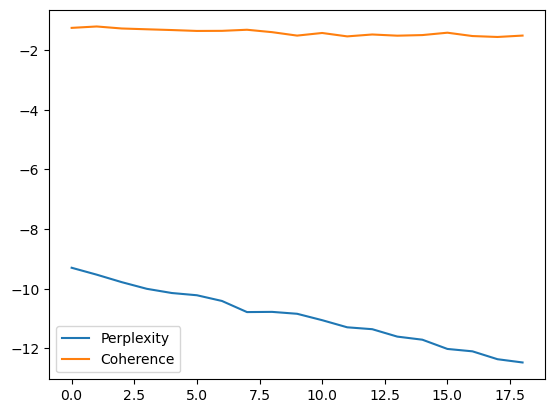

In [156]:
## Plot perplexity against coherence
plt.plot(perplexity)
plt.plot(coherence)
plt.legend(["Perplexity", "Coherence"])
plt.show()

The coherence seems to be the same across all topics, meaning adding more topics does not extract more meaningful information. 

Even a topic number of 2 seems to have reached the maximum. This leads me to think that the topics are not really representive of the documents (lyrics). A possible reason for this could be due to the fact that lyrics are generally unique and there might not be real topics within my dataset. The processing and cleaning of the lyrics also have a large impact on this - are the final tokens not a meaningful representive of the lyrics e.g., filler words.

In [206]:
## Observing the topics for these models
models[6].print_topics() # Change the number from 0-18

[(0,
  '0.005*"love" + 0.003*"feel" + 0.003*"want" + 0.003*"never" + 0.003*"say" + 0.003*"time" + 0.003*"come" + 0.003*"away" + 0.003*"heart" + 0.003*"way"'),
 (1,
  '0.002*"love" + 0.002*"time" + 0.001*"want" + 0.001*"come" + 0.001*"believ" + 0.001*"way" + 0.001*"feel" + 0.001*"danc" + 0.001*"see" + 0.001*"make"'),
 (2,
  '0.001*"love" + 0.001*"live" + 0.001*"want" + 0.001*"take" + 0.001*"life" + 0.001*"feel" + 0.001*"make" + 0.001*"time" + 0.001*"never" + 0.001*"come"'),
 (3,
  '0.001*"love" + 0.001*"come" + 0.001*"back" + 0.001*"live" + 0.001*"feel" + 0.001*"time" + 0.001*"see" + 0.001*"blood" + 0.001*"never" + 0.001*"life"'),
 (4,
  '0.002*"love" + 0.002*"christma" + 0.001*"want" + 0.001*"come" + 0.001*"say" + 0.001*"need" + 0.001*"never" + 0.001*"see" + 0.001*"without" + 0.001*"make"'),
 (5,
  '0.001*"come" + 0.001*"love" + 0.001*"take" + 0.001*"want" + 0.001*"time" + 0.001*"away" + 0.001*"girl" + 0.001*"see" + 0.001*"say" + 0.001*"need"'),
 (6,
  '0.004*"love" + 0.003*"want" + 0.

The topics do not seem to be very meaningful - very similar and overlapping terms. The most common terms e.g., 'love', 'want', 'feel' are found in almost all topics. This could be because of my dataset and songs in general tend to focus on love themes (even if different emotions e.g., joy, sadness).

#### 3.3.2 LDA Model

After multiple trial and error, using a number of topics from 3-7 and passes from 5-20, I have chosen 7 topics as looking at the topics manually I felt this gave the most coherent and diverse topics.

In [446]:
## Create a model with 7 topics, as there are 7 emotions in the dataset which could provide a decent distinction of topics

lda_model_7 = gensim.models.LdaMulticore(tfidf_corp, # The corpus to use
                                         num_topics=7, # The number of topics to split the data
                                         id2word=dictionary, # Word dictionary
                                         passes=15, # How many passes through the corpus during training
                                         workers=7, # How many workers to parallelise the job (CPU cores - 1)
                                         random_state = 1)

In [447]:
## Print the topics
lda_model_7.print_topics()

[(0,
  '0.001*"weh" + 0.001*"mek" + 0.000*"gyal" + 0.000*"victoria" + 0.000*"pon" + 0.000*"voyag" + 0.000*"foolin" + 0.000*"love" + 0.000*"seh" + 0.000*"nigga"'),
 (1,
  '0.005*"love" + 0.003*"want" + 0.003*"feel" + 0.003*"come" + 0.003*"time" + 0.003*"never" + 0.003*"way" + 0.003*"say" + 0.003*"take" + 0.003*"need"'),
 (2,
  '0.000*"tusk" + 0.000*"christoph" + 0.000*"marcelin" + 0.000*"unchain" + 0.000*"scoobi" + 0.000*"unprepar" + 0.000*"roulett" + 0.000*"contort" + 0.000*"squash" + 0.000*"werewolf"'),
 (3,
  '0.000*"robot" + 0.000*"rock" + 0.000*"wiggl" + 0.000*"merlin" + 0.000*"vie" + 0.000*"nothing" + 0.000*"funk" + 0.000*"pum" + 0.000*""whatll"" + 0.000*"uptight"'),
 (4,
  '0.000*"jingl" + 0.000*"blah" + 0.000*"wha" + 0.000*"snowman" + 0.000*"waterfront" + 0.000*"unlov" + 0.000*"adonai" + 0.000*"marigold" + 0.000*"seabird" + 0.000*"tail"'),
 (5,
  '0.001*"dey" + 0.001*"" + 0.000*"come" + 0.000*"afterlif" + 0.000*"shanti" + 0.000*"timeless" + 0.000*"hypocrit" + 0.000*"merrili" + 0

In [448]:
## Calculate the coherence and perplexity measures
coherence_lda = CoherenceModel(lda_model_7, ## Which model?
                                    corpus=tfidf_corp, ## On what corpus?
                                    dictionary=dictionary, ## What should be our dictionary of reference?
                                    coherence='u_mass').get_coherence() ## What type of coherence (U_mass)

perplexity = lda_model_7.log_perplexity(tfidf_corp) # Log perplexity

print(f"Coherence: {coherence_lda}") # Higher the better
print(f"Perplexity: {perplexity}")  # Lower the better

Coherence: -13.50936507116957
Perplexity: -9.770499466048308


This low coherence means that the topics are not actually a good fit for this dataset/meaningful real context. However, I will be using these topics for this project, as proof-of-concept. 

In [449]:
## Visualise the topics

pyLDAvis.enable_notebook() ## If you're using a notebook env

lda_display = gensimvis.prepare(lda_model_7, ## the model
                                tfidf_corp, ## the TF-IDF corpus
                                dictionary, ## Our dictionary
                                #mds='mmds',
                                R=10, ## How many topics to show
                                n_jobs=7, 
                                mds='TSNE') ## T-distributed Stochastic Neighbourhood Embedding > dim reduction

pyLDAvis.display(lda_display) 

Most of the terms fall within topic 1 above, with encompass the theme of 'love' and 'romance'. This highlights a large limitation of using this topic modelling for this dataset for song recommendation.

In [12]:
## Load the model (if running from this point)
from gensim.models import LdaMulticore
lda_model_7 = LdaMulticore.load('gensim_lda_model.model')

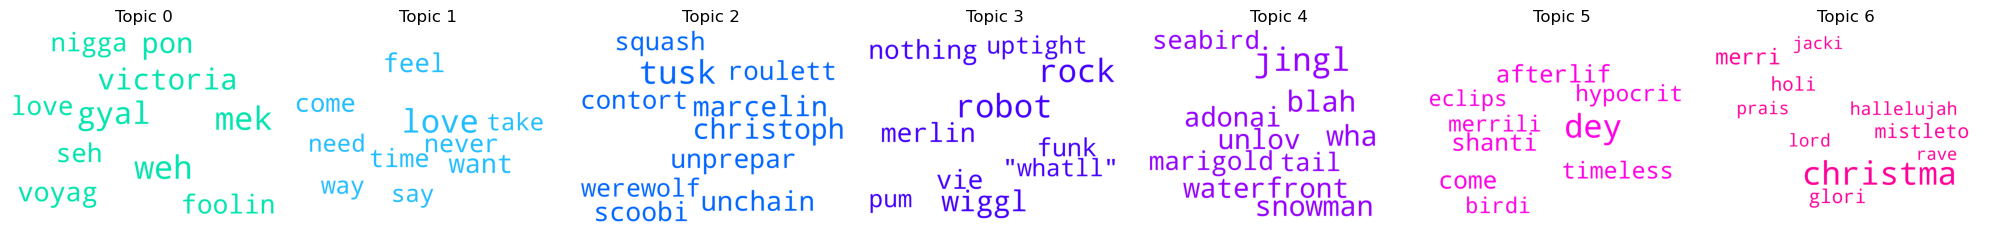

In [14]:
## Plot wordclouds for each topic

# Use a custom colour option
custom_colors = ['#00E4AE', '#20BDFF', '#0066FF', '#4400FF', '#9500FF', '#FF00E6', '#FF0099']

# Replace the cols definition with your chosen palette (e.g., using custom_colors)
cols = custom_colors  # or ocean_colors or teal_colors

stop_words = stopwords.words('english')

# Initiate the cloud format
cloud = WordCloud(stopwords=stop_words,
                 background_color='white',
                 width=2500,
                 height=1800,
                 max_words=10,
                 prefer_horizontal=1.0,
                 color_func=lambda *args, **kwargs: cols[i])

# Use the topics from the LDA model
topics = lda_model_7.show_topics(formatted=False)

# Create 7 subplots for each topic
fig, axes = plt.subplots(1, 7, figsize=(20,20), sharex=True, sharey=True)

# Plot each topic's word cloud
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=12))
    plt.gca().axis('off')

# Save as image
plt.savefig('topic_word_clouds.png', 
            dpi=300,              # High resolution
            bbox_inches='tight',  # Removes extra whitespace
            pad_inches=0.1)       # Adds small padding

# Display it
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()



Source of code for the word cloud: [Topic modeling visualization](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/).

**Interpretation of Topics**
- Topic 0: Caribbean-Inspired
  - Terms e.g., 'weh' (where), 'gyal' (girl), 'pon' (on), suggest the use of Caribbean dialects, and this this topic could be associated with reggae, dancehall, or Afro-Caribbean music.
- Topic 1: Love & Relationships
  - Terms e.g., "love," "want," "feel," suggest a heavy focus on love, emotions and romance. This is a very common theme, and most of the songs fall in this topic.
- Topic 2: Abstract Imagery & Supernatural
  - The terms are unusual and fragmented. There are references to randomness ("roulett"), supernatural themes ("werewolf"), and abstract imagery ("contort", "squash", "unprepar"). This suggests a theme of surrealism, or experimental music.
- Topic 3: Funk, Rock & Groove
  - Terms e.g.,  "robot," "rock,", "funk", "wiggl" suggests a theme rooted in groove-based music like funk, rock, or electronic dance music. The inclusion of robot might indicate robotic or futuristic elements.
- Topic 4: Winter & Nature-Inspired
  - Terms e.g., "jingl", "snowman" suggest winter-themed music, while terms including "waterfront", "seabird", and "marigold" could hint at nature and peaceful settings. This topic may cover festive, spiritual, or nostalgic winter songs.
- Topic 5: Philosophical & Existential Themes
  - This topic is harder to find a theme for but terms like "afterlife", "timeless", "eclipse", "hypocrite", might suggest a focus on reflection/questioning or spirituality.
- Topic 6: Christmas & Religious
  - Terms e.g., "christma," "merri," "mistleto," "glori," "holi," "hallelujah," "lord," clearly represents religious or holiday-themed music, particularly Christian and Christmas songs. Words like hallelujah, glory, and praise align with gospel or worship music, while mistletoe and merry indicate Christmas pop classics.

Now, we need to calculate the distribution of documents/lyrics across topics.

In [500]:
## Observe the distribution of topic for the first document
lda_model_7[tfidf_corp[0]] # Topic 1 is dominant i.e., has the maximum document contribution

[(0, 0.022741517),
 (1, 0.8635487),
 (2, 0.02274008),
 (3, 0.022740806),
 (4, 0.022740804),
 (5, 0.02274354),
 (6, 0.022744548)]

In [503]:
## Define a function which displays the distribution of topics across a given document

def topic_distribution(document):
    # Assert an error if the document is not found in the corpus
    assert(document in range(len(tfidf_corp))), "Document number outside of bounds."
    # Loop through each topic
    for topic_num in range(lda_model_7.num_topics):
        # Display the topic distribution
        print(f"Topic {topic_num} has {round(lda_model_7[tfidf_corp[document]][topic_num][1]*100, 2)} % contribution towards document {document}.")

In [505]:
topic_distribution(0)

Topic 0 has 2.27 % contribution towards document 0.
Topic 1 has 86.35 % contribution towards document 0.
Topic 2 has 2.27 % contribution towards document 0.
Topic 3 has 2.27 % contribution towards document 0.
Topic 4 has 2.27 % contribution towards document 0.
Topic 5 has 2.27 % contribution towards document 0.
Topic 6 has 2.27 % contribution towards document 0.


In [515]:
## Format the topic distribution of all the lyrics as a dictionary
dictionary_model =\
    {document_no: 
        {lda_model_7[tfidf_corp[document_no]][topic][0]:
             lda_model_7[tfidf_corp[document_no]][topic][1] 
                 for topic in range(len(lda_model_7[tfidf_corp[document_no]]))
        }
            for document_no in range(len(tfidf_corp))
    } 

## Update the dictionary to include 0 if a topic is not found in the document (i.e., has zero impact)
numDocs = len(dictionary_model) # How many documents (lyrics) do we have (10,000)
numTopics = lda_model_7.num_topics # How many topics do we have (7)

# Loop through each document
for doc in range(numDocs):
    # Loop through 1-7 (number of topics)
    for topic in range(numTopics):
        # If the topic cannot be found, update the topic to contain a distribution of 0
        if topic not in dictionary_model[doc].keys():
            dictionary_model[doc].update({topic:0})  

In [520]:
## Translate to a df
topic_distr =\
    {'Topic_distr_' + str(topic):
        [dictionary_model[doc][topic] 
             for doc in dictionary_model.keys()]
        for topic in range(numTopics)
    } 
topics_data = pd.DataFrame(topic_distr)
topics_data.head()

,Topic_distr_0,Topic_distr_1,Topic_distr_2,Topic_distr_3,Topic_distr_4,Topic_distr_5,Topic_distr_6
0,0.022741,0.863549,0.022740,0.022741,0.022741,0.022743,0.022744
1,0.035486,0.787082,0.035483,0.035490,0.035484,0.035489,0.035488
2,0.024531,0.852813,0.024529,0.024530,0.024530,0.024533,0.024533
3,0.141410,0.750485,0.021616,0.021611,0.021626,0.021613,0.021675
4,0.019910,0.880539,0.019909,0.019910,0.019909,0.019912,0.019911


In [522]:
topics_data.shape

(10000, 7)

In [527]:
## Join this to the lyrics dataset
lyrics_combined = pd.concat([lyrics_clean, topics_data], axis = 1) # Join on their row indicies
lyrics_combined.head()

,name,album_name,artists,lyrics,lyrics_length,emotion,lyric_tokens,Topic_distr_0,Topic_distr_1,Topic_distr_2,Topic_distr_3,Topic_distr_4,Topic_distr_5,Topic_distr_6
0,They Want War,NaN,U.D.O.,They are young and they're kids\n And believe ...,1285,disgust,"[young, kid, believ, see, told, walk, away, op...",0.022741,0.863549,0.022740,0.022741,0.022741,0.022743,0.022744
1,Cry,Asphodel,The Machine In The Garden,I cry for the things you know\n the things tha...,285,sadness,"[cri, must, say, fli, soul, air, cri, see, pla...",0.035486,0.787082,0.035483,0.035490,0.035484,0.035489,0.035488
2,Know Better (feat. Mister Blonde),NaN,JayKode,We stay up till we see the sun\n But I can nev...,1223,fear,"[stay, till, see, sun, never, enough, vision, ...",0.024531,0.852813,0.024529,0.024530,0.024530,0.024533,0.024533
3,Baltimore,NaN,The Drifters,Beat-up little seagull\n On a marble stair\n T...,786,sadness,"[beat-up, littl, seagul, marbl, stair, tryin, ...",0.141410,0.750485,0.021616,0.021611,0.021626,0.021613,0.021675
4,This Goodbye,Porcelain Heart,Beth Crowley,My world caught fire\n You're the one who lit ...,1347,sadness,"[world, caught, fire, lit, spark, play, match,...",0.019910,0.880539,0.019909,0.019910,0.019909,0.019912,0.019911


### 3.4 Explore the songs by Topic

In [16]:
# ## Load the data
# lyrics_combined = pd.read_csv("Data/lyrics_complete.csv")

In [77]:
## Retrieve and store the dominant topic of each song

cols_to_check = ['Topic_distr_0', 'Topic_distr_1', 'Topic_distr_2', 'Topic_distr_3', 'Topic_distr_4', 'Topic_distr_5', 'Topic_distr_6']

lyrics_combined["dominant_topic"] = lyrics_combined[cols_to_check].idxmax(axis=1).str.extract("(\d+)").astype(int) # Retrieve the number in the column names with the max value in each row

<>:5: DeprecationWarning: invalid escape sequence '\d'
<>:5: DeprecationWarning: invalid escape sequence '\d'
C:\Users\isabe\AppData\Local\Temp\ipykernel_46788\3037208964.py:5: DeprecationWarning: invalid escape sequence '\d'
  lyrics_combined["dominant_topic"] = lyrics_combined[cols_to_check].idxmax(axis=1).str.extract("(\d+)").astype(int) # Retrieve the number in the column names with the max value in each row


In [652]:
## Add a column with the topic theme

# Define the mapping
topic_mapping = {
    0: "Caribbean-Inspired",
    1: "Love & Relationships",
    2: "Abstract Imagery & Supernatural",
    3: "Funk, Rock & Groove",
    4: "Winter & Nature-Inspired",
    5: "Philosophical & Existential",
    6: "Christmas & Religious"
}

# Map the topic numbers to their names
lyrics_combined['dominant_topic_name'] = lyrics_combined['dominant_topic'].map(topic_mapping)

In [79]:
## Observe the first few rows
lyrics_combined.head(2)

,name,album_name,artists,lyrics,lyrics_length,emotion,lyric_tokens,Topic_distr_0,Topic_distr_1,Topic_distr_2,Topic_distr_3,Topic_distr_4,Topic_distr_5,Topic_distr_6,dominant_topic,dominant_topic_name
0,They Want War,NaN,U.D.O.,They are young and they're kids\n And believe ...,1285,disgust,"['young', 'kid', 'believ', 'see', 'told', 'wal...",0.022741,0.863549,0.022740,0.022741,0.022741,0.022743,0.022744,1,Love & Relationships
1,Cry,Asphodel,The Machine In The Garden,I cry for the things you know\n the things tha...,285,sadness,"['cri', 'must', 'say', 'fli', 'soul', 'air', '...",0.035486,0.787082,0.035483,0.035490,0.035484,0.035489,0.035488,1,Love & Relationships


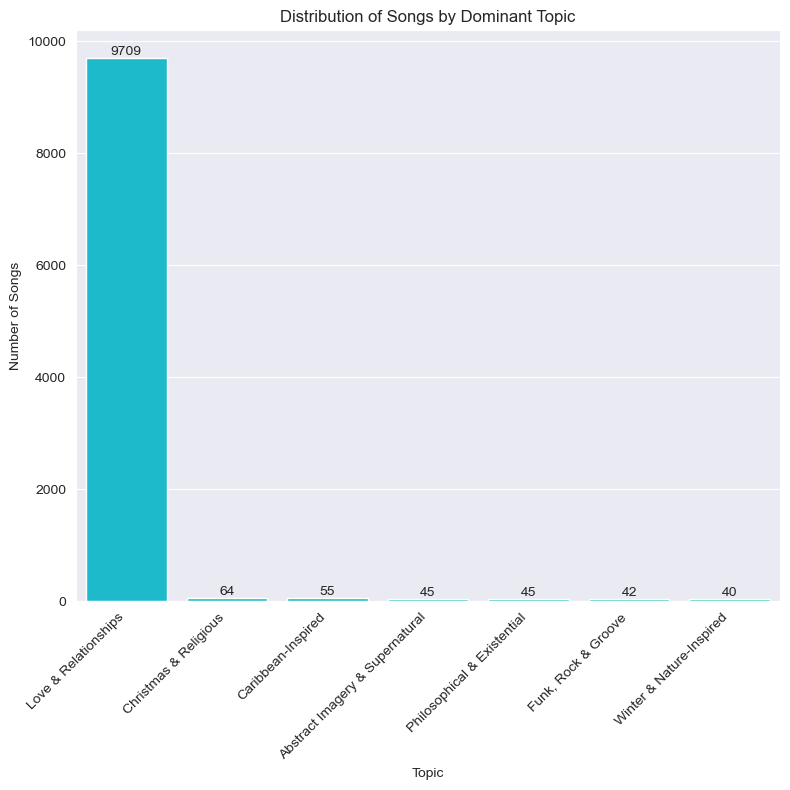

In [101]:
## Plot the distribution of topics

# Create a dataframe with the count of each emotion
topic_count = pd.DataFrame(lyrics_combined['dominant_topic_name'].value_counts()).sort_values(by = 'count', ascending = False)

# Set a style
sns.set_style("darkgrid")

# Set a figure size
plt.figure(figsize=(8, 8))

# Plot the barplot
ax = sns.barplot(data = topic_count,
            x = 'dominant_topic_name',
            y = 'count',
            palette = custom_palette, # Use the custom palette - sns.color_palette("blend:#00D1E9,#00e4ae", n_colors= 7)
            hue = 'dominant_topic_name'
           )

# Adjust the x-axis labels
plt.xticks(rotation= 45, # rotating labels
           horizontalalignment = 'right' , # aligning them with the bars
           fontweight = 'light',
           fontsize = 'medium' # setting the fonts
          )

# Add a title and labels
plt.title('Distribution of Songs by Dominant Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Songs')

# Add the song count as annotations on the bar
for i in ax.containers:
    ax.bar_label(i,)

# Save as an image
plt.savefig('topic_song_distribution.png', 
            dpi=300,              # High resolution
            bbox_inches='tight',  # Removes extra whitespace
            pad_inches=0.1)       # Adds small padding

# Display the plot
plt.tight_layout()
plt.show()


Extremely unbalanced between the topics.

In [658]:
## Plot the distribution of topic by emotion 

lyrics_combined.groupby('emotion')['dominant_topic_name'].value_counts().sort_values(ascending = False)

emotion   dominant_topic_name            
joy       Love & Relationships               4598
sadness   Love & Relationships               2425
anger     Love & Relationships               1148
neutral   Love & Relationships                691
fear      Love & Relationships                681
disgust   Love & Relationships                137
joy       Christmas & Religious                33
          Caribbean-Inspired                   31
surprise  Love & Relationships                 29
joy       Philosophical & Existential          26
          Funk, Rock & Groove                  24
          Winter & Nature-Inspired             22
neutral   Christmas & Religious                20
          Abstract Imagery & Supernatural      20
joy       Abstract Imagery & Supernatural      20
neutral   Caribbean-Inspired                   12
          Winter & Nature-Inspired             12
          Philosophical & Existential          11
          Funk, Rock & Groove                   8
sadness 

In [646]:
## Observe an example of unique groupings 
# Sad Christmas/Religious Song
lyrics_combined['lyrics'][(lyrics_combined['emotion'] == 'sadness') & (lyrics_combined['dominant_topic_name'] == 'Christmas & Religious')].iloc[0]

"Lord\n Endow me\n Lord lord lord lord lord\n Endow me\n Lord... Endow me, endow me\n Endow me\n Lord lord lord lord... anybody want God to endow?\n Endow me... I promise if you let go and let God, He will endow you\n Lord... Yeaaaaaah\n Endow me\n Looooord Lord lord lord lord\n With the power... With the power of the holy ghost\n Oooohhhhhh ooooohhhhh\n Endow me\n Endow me ...sickness will be healed\n Lord... I'm tired of being the way I am, God endow me\n Endow me... Oh wrap me in the cradle of His arms\n Lord lord lord lord, Ohhhh Endow me\n Endow me... Come on it's your time, it's your time, it's your time\n Lord\n Endooooow... Endow me\n Anybody need God to endow them\n tonight, you ought to lift your hands and say\n Lord lord lord lord\n You will live, Endoooooow\n Endow me... Sick of the enemy coming in\n and out of my life telling me what I can't do\n Lord\n Endow me... Do you believe God will do it,\n do you believe God will do it, do you believe God will?\n Lord lord lord lor

In [20]:
lyrics_combined[(lyrics_combined['emotion'] == 'sadness') & (lyrics_combined['dominant_topic_name'] == 'Christmas & Religious')].iloc[0]

name                                                            Endow Me
album_name                                                           NaN
artists                                              "Le'Andria Johnson"
lyrics                 Lord\n Endow me\n Lord lord lord lord lord\n E...
lyrics_length                                                       1030
emotion                                                          sadness
lyric_tokens           ['lord', 'endow', 'lord', 'lord', 'lord', 'lor...
Topic_distr_0                                                    0.04561
Topic_distr_1                                                   0.321435
Topic_distr_2                                                   0.045645
Topic_distr_3                                                   0.045608
Topic_distr_4                                                   0.045609
Topic_distr_5                                                   0.045612
Topic_distr_6                                      

In [650]:
# Disgust - Funk, Rock & Groove 
lyrics_combined['lyrics'][(lyrics_combined['emotion'] == 'disgust') & (lyrics_combined['dominant_topic_name'] == 'Funk, Rock & Groove')].iloc[0]

"No, I don't care for your metal looks\n I don't care for your bleeps and bloops\n Go away, why don't you just shut up?\n Your crazy smile, digital dial\n I hate your every bolt and screw\n I don't like anything about you\n You're a dirty robot, I'm a dirty robot\n You're a dirty robot, I'm a dirty robot\n You're a dirty robot, I'm a dirty robot\n You're a dirty robot, I'm a dirty robot\n Yes, everyday I've been thinking 'bout you\n In my dreams, we've been making out\n Isn't that what human life's about? No\n My circuitry comes off the scale\n Baby, got the hots for you\n My index sent a shock right through\n My body needs you, my body needs you\n You're a dirty robot, I'm a dirty robot\n You're a dirty robot, I'm a dirty robot\n You're a dirty robot, I'm a dirty robot\n You're a dirty robot, I'm a dirty robot\n You're a dirty robot, I'm a dirty robot\n You're a dirty robot, I'm a dirty robot\n You're a dirty robot, I'm a dirty robot\n You're a dirty robot, you're a dirty robot\n I'm 

In [660]:
# Surprise - Philosophical & Existential
lyrics_combined['lyrics'][(lyrics_combined['emotion'] == 'surprise') & (lyrics_combined['dominant_topic_name'] == 'Philosophical & Existential')].iloc[0]

'What now?\n ♪\n What now?\n What now?\n '

Just mostly instrumental with this beginning so that's why. Song:  What Now by No BS! Brass Band

In [672]:
lyrics_combined['lyrics'][(lyrics_combined['emotion'] == 'fear') & (lyrics_combined['dominant_topic_name'] == 'Winter & Nature-Inspired')].iloc[0]

'Of all the wonders that I yet have heard, it seems to me most strange that men should fear, seeing that death, a necessary end, will come when it will come\n (Caesar, Julius Caesar)\n When beggars die, there are no comets seen\n (Calpurnia, Julius Caesar)\n Cowards die many times before their death.\n (Caesar, Julius Caesar)\n '

This seems more philosophical than winter/nature.

In [18]:
# Angry/Disgust christmas song
lyrics_combined['lyrics'][(lyrics_combined['emotion'] == 'disgust') & (lyrics_combined['dominant_topic_name'] == 'Christmas & Religious')].iloc[0]

'My horrendous concoction, defaced and erased\n A beastly corpus eloquently drained\n Carbonated and flavored at will\n Grinded, blended,\n a milkshake highly recommended\n Necrotic nutrients decompose\n Your body is mine for the taking\n Shot thrice, cranium excavated\n Delusional amour, your cadaver my shrine\n Pleasure holes depraved by the relentless thrust of my blade\n My sweet post-mortal fuck!\n Vintage of the damned, succulent and frail\n An eternal silence by canine excrement\n An eternal silence by canine excrement\n Yours is mine for the raping\n Shot thrice, exsanguinated\n Delusional amour, your cadaver my shrine\n Pleasure holes depraved by the relentless thrust of my blade\n Delicious gory banquet,\n Seved up to fill my needs\n My appetite temporarily pleased\n Delicious gory banquet,\n Seved up to fill my needs\n My appetite temporarily pleased, bleed\n Cadaverous banquet, vintage of the dead\n Chasing my meat through her urethra,\n mashed up to fulfill my needs\n My p

Possible words like 'feast' and 'shrine' maybe religious.

In [28]:
lyrics_combined['lyrics'][(lyrics_combined['emotion'] == 'anger') & (lyrics_combined['dominant_topic_name'] == 'Christmas & Religious')].iloc[0]

"My mind plays tricks on me every time I say something\n It brings evil voices out of my head, and talks to me vulgar\n Then suddenly, I started raving\n Chronic schizophrenia\n Chronic schizophrenia\n Chronic schizophrenia\n Chronic schizophrenia\n But when I have bad luck, I'll always hear evil voices walking to me vulgar\n Everywhere I go riding on the CTA bus, all I hear is vulgarity\n I hear no music at all\n Chronic schizophrenia\n Chronic schizophrenia\n Chronic schizophrenia\n Chronic schizophrenia\n Riding in the streets with no music sucks\n Everywhere I go, I cruise the streets being called an asshole\n Plus I'm being ridiculed and called a bum and called stupid\n Chronic schizophrenia\n Chronic schizophrenia\n Chronic schizophrenia\n Chronic schizophrenia\n Pontiac, we build excitement"

In [30]:
lyrics_combined[(lyrics_combined['emotion'] == 'anger') & (lyrics_combined['dominant_topic_name'] == 'Christmas & Religious')].iloc[0]

name                                               Chronic Schizophrenia
album_name                                                     Rush Hour
artists                                                    Wesley Willis
lyrics                 My mind plays tricks on me every time I say so...
lyrics_length                                                        786
emotion                                                            anger
lyric_tokens           ['mind', 'play', 'trick', 'everi', 'time', 'sa...
Topic_distr_0                                                   0.039306
Topic_distr_1                                                   0.312205
Topic_distr_2                                                   0.039302
Topic_distr_3                                                   0.039302
Topic_distr_4                                                   0.039302
Topic_distr_5                                                   0.039309
Topic_distr_6                                      

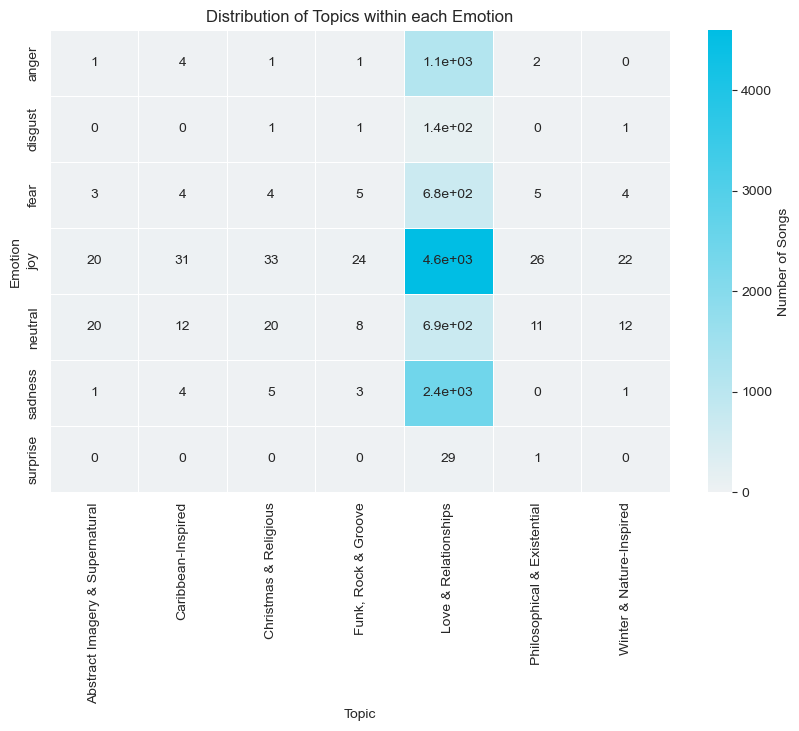

In [93]:
## Plot the distribution of topic by emotion 

# Group by emotion and dominant topic, count the occurrences, and unstack the results (if empty fill with 0)
emotion_topic_counts = lyrics_combined.groupby('emotion')['dominant_topic_name'].value_counts().unstack(fill_value=0)

# Define a custom color map
custom_cmap = sns.color_palette("light:#00bee4", as_cmap=True)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(emotion_topic_counts, annot=True, cmap=custom_cmap, linewidths=0.5, cbar_kws={'label': 'Number of Songs'})

# Add labels
plt.xlabel('Topic')
plt.ylabel('Emotion')
plt.title('Distribution of Topics within each Emotion')

# Save as an image
plt.savefig('topic_emotion_heatmap.png', 
            dpi=300,              # High resolution
            bbox_inches='tight',  # Removes extra whitespace
            pad_inches=0.1)       # Adds small padding

# Display it
plt.show()

## 4. Song Recommendation System

### 4.1 Complete Song Recommendation Dataset

In [702]:
lyrics_combined.head(2)

,name,album_name,artists,lyrics,lyrics_length,emotion,lyric_tokens,Topic_distr_0,Topic_distr_1,Topic_distr_2,Topic_distr_3,Topic_distr_4,Topic_distr_5,Topic_distr_6,dominant_topic,dominant_topic_name
0,They Want War,NaN,U.D.O.,They are young and they're kids\n And believe ...,1285,disgust,"[young, kid, believ, see, told, walk, away, op...",0.022741,0.863549,0.022740,0.022741,0.022741,0.022743,0.022744,1,Love & Relationships
1,Cry,Asphodel,The Machine In The Garden,I cry for the things you know\n the things tha...,285,sadness,"[cri, must, say, fli, soul, air, cri, see, pla...",0.035486,0.787082,0.035483,0.035490,0.035484,0.035489,0.035488,1,Love & Relationships


In [704]:
## Save to .csv
lyrics_combined.to_csv('Data/lyrics_complete.csv', index=False)

In [782]:
## Create a dataframe with only the columns needed for song recommendation

# Create a list of needed columns
cols_to_keep = ['name', 'artists', 'emotion', 'Topic_distr_0', 'Topic_distr_1', 
                'Topic_distr_2', 'Topic_distr_3', 'Topic_distr_4', 'Topic_distr_5', 
                'Topic_distr_6']

# Create a copy of the df and filter it
song_rec_df = lyrics_combined[cols_to_keep].copy()
song_rec_df.head(2)

,name,artists,emotion,Topic_distr_0,Topic_distr_1,Topic_distr_2,Topic_distr_3,Topic_distr_4,Topic_distr_5,Topic_distr_6
0,They Want War,U.D.O.,disgust,0.022741,0.863549,0.022740,0.022741,0.022741,0.022743,0.022744
1,Cry,The Machine In The Garden,sadness,0.035486,0.787082,0.035483,0.035490,0.035484,0.035489,0.035488


In [784]:
## Save to .csv
song_rec_df.to_csv('Data/song_recommendation.csv', index=False)

Now, using this complete dataset, I will build a song recommendation system using the emotion and topic distribution detected from the user's prompt to find the most similar songs.

### 4.2 Key Functions

Here are the key functions used for building the song recommendation app.

In [52]:
## Load the dataset used for song recommendation
song_rec_df = pd.read_csv('Data/song_recommendation.csv')
song_rec_df.head(2)

,name,artists,emotion,Topic_distr_0,Topic_distr_1,Topic_distr_2,Topic_distr_3,Topic_distr_4,Topic_distr_5,Topic_distr_6
0,They Want War,U.D.O.,disgust,0.022741,0.863549,0.022740,0.022741,0.022741,0.022743,0.022744
1,Cry,The Machine In The Garden,sadness,0.035486,0.787082,0.035483,0.035490,0.035484,0.035489,0.035488


In [711]:
## Create a function to detect the prompt's emotion

# Load the BERT model chosen to detect the emotion
michelle = pipeline(task="text-classification", model="michellejieli/emotion_text_classifier", top_k=1) # top_k=1 to get only the top emotion

def detect_prompt_emotion(prompt):
    # Perform quick, basic cleaning on the prompt
    prompt = prompt.strip().lower().replace('\n', '')

    # Predict the emotion
    try:
        emotion = michelle(prompt)
    except RuntimeError: # Occurs if the length of the prompt exceeds limit (though unlikely)
        print("Sorry! That was too long. Could you try shortening your entry?")

    # Return just the label
    return emotion[0][0]['label']

In [719]:
## Use a user prompt

prompt = "My birthday was today. I had a lovely chocolate cake."

In [721]:
detect_prompt_emotion(prompt)

'joy'

In [724]:
## Create a function to clean the user prompt using the same method as for the other lyrics

# Initialise a stemmer to get to the root word
stemmer = SnowballStemmer(language='english')
## Create a list of stopwords and punctuation
remove = stopwords.words('english')
remove.extend(string.punctuation) # Extend the list with punctuation

# Extend the remove list with common contractions
contractions = ["they'r", "they'v", "can't", "won't", "don't", "i'm", "it's", "i'll", "ain't", "can't", "won't", "don't", "i'm", "it's", "he's", "she's"]
remove.extend(contractions)

## Initalise the tokeniser
tokeniser = WhitespaceTokenizer() # Extracts the tokens without whitespaces, new line and tabs 

def preprocess_prompt(prompt):
    """ Cleans up a user prompt for retrieving the topic distribution

    Parameters
    ----------
    prompt : string
        A text string that you want to clean

    Returns
    -------
    The same string but cleaned up, stemmed and tokenised
    """  
    # Apply pre-token cleaning
    prompt = prompt.lower().strip()
    
    # Tokenise the prompt using the whitespace tokeniser
    prompt_tokens = tokeniser.tokenize(prompt)

    # Apply post-token cleaning
    prompt_tokens = [word.strip(string.punctuation) for word in prompt_tokens]
    prompt_tokens = [word for word in prompt_tokens if word not in remove] # Remove stopwords and punctuation

    
    prompt_tokens_clean = []
    for word in prompt_tokens:
        try:
            word = str(w2n.word_to_num(word)) # Convert numbers which are written as text e.g. ten -> 10
        except:
            word = word
        prompt_tokens_clean.append(word)
        
    prompt_tokens_clean = [re.sub(r'\d+', '', word) for word in prompt_tokens_clean] # Remove numbers
    
    prompt_tokens_clean = [stemmer.stem(word) for word in prompt_tokens_clean] # Apply the stemmer
    prompt_tokens_clean = [word for word in prompt_tokens_clean if word not in remove] # In case some words became stopwords

    return prompt_tokens_clean

In [726]:
preprocess_prompt(prompt)

['birthday', 'today', 'love', 'chocol', 'cake']

In [748]:
## Save the created dictionary and LDA model from topic modelling

# Save the dictionary
dictionary.save('gensim_dictionary.dict')

# Save the LDA model
lda_model_7.save('gensim_lda_model.model')

When saving the model file, it creates:
- Model file (.model): This is the main file containing the trained model, including all the necessary parameters and configurations.
- *.state file: This stores the state of the model's parameters during training.
- *.id2word file: This contains the dictionary mapping of word IDs to words.
- *.lda file: This stores additional information about the LDA model.

In [ ]:
## To load the dictionary and LDA model

# Load the saved dictionary
# from gensim.corpora import Dictionary
# dictionary = Dictionary.load('gensim_dictionary.dict')

# # Load the saved LDA model
# from gensim.models import LdaMulticore
# lda_model = LdaMulticore.load('gensim_lda_model.model')


In [728]:
dictionary

In [730]:
lda_model_7

In [751]:
## Create a function to retrieve the topic distribution of the user prompt.

def get_topic_distribution(user_prompt): #or include dictionary and lda in parameters too
    # Preprocess the user prompt
    tokens = preprocess_prompt(user_prompt)
    
    # Convert the token to  a Bag of Words (BoW) using the dictionary
    bow = dictionary.doc2bow(tokens)
    
    # Get the topic distribution (inference on new text)
    topic_distribution = lda_model_7.get_document_topics(bow)
    
    return topic_distribution 

In [753]:
get_topic_distribution(prompt)

[(0, 0.023856858),
 (1, 0.85681295),
 (2, 0.023855083),
 (3, 0.023897886),
 (4, 0.023857182),
 (5, 0.023861755),
 (6, 0.023858272)]

In [755]:
## Final user prompt function
def process_user_prompt(prompt):
    # Detect emotion from the user prompt
    emotion = detect_prompt_emotion(prompt)
    
    # Get the topic distribution of the user prompt
    topic_distribution = get_topic_distribution(prompt)
    
    return emotion, topic_distribution

In [757]:
process_user_prompt(prompt)

('joy',
 [(0, 0.02385686),
  (1, 0.8568129),
  (2, 0.023855085),
  (3, 0.023898),
  (4, 0.023857184),
  (5, 0.023861757),
  (6, 0.023858273)])

In [862]:
## Create a function which returns the matching emotion to the user

def match_emotion(user_emotion, song_data):
    # Filter the dataframe for only songs with the same emotion
    song_data_filtered = song_data[song_data['emotion'] == user_emotion].copy()
    return song_data_filtered
    

In [864]:
match_emotion('joy', song_rec_df).head()

,name,artists,emotion,Topic_distr_0,Topic_distr_1,Topic_distr_2,Topic_distr_3,Topic_distr_4,Topic_distr_5,Topic_distr_6
5,Took My Place,Third Day,joy,0.024450,0.853301,0.024448,0.024449,0.024449,0.024452,0.024452
17,Megumi The Milkyway Above,Connan Mockasin,joy,0.297263,0.589690,0.022607,0.022606,0.022612,0.022613,0.022609
18,The Grits (featuring 8-Off) (feat. 8-OFF),"Cappadonna, 8-Off",joy,0.013001,0.922309,0.012939,0.012947,0.012933,0.012936,0.012935
23,To Each His Own,Marty Robbins,joy,0.023913,0.856521,0.023911,0.023912,0.023912,0.023915,0.023914
24,Freakshow,The Honeydogs,joy,0.025644,0.660143,0.025539,0.025537,0.025569,0.211576,0.025785


**What is Cosine Similarity?**

Cosine similarity is a metric used to measure how similar two vectors are, regardless of their magnitude. It calculates the cosine of the angle between two vectors, which gives a measure of how much they point in the same direction.

Each song has a vector representing its topic distribution, as well as the user prompt's topic distribution. Therefore, cosine similarity can be calculated between them to show how similar they are, helping to find the most relevant songs.

Cosine similarity ranges from -1 to 1:
- 1 means the vectors are perfectly similar (point in the same direction).
- 0 means there is no similarity (the vectors are orthogonal).
- -1 means the vectors are completely dissimilar (point in opposite directions).

In [796]:
## Extract song topic distributions from the dataframe

# Extract the columns
song_topic_cols = [col for col in song_rec_df.columns if col.startswith('Topic_distr')]

# Turn into a numpy array
song_topic_array = song_rec_df[song_topic_cols].to_numpy()

In [798]:
song_topic_array

array([[0.02274148, 0.86354941, 0.02274007, ..., 0.02274079, 0.02274331,
        0.02274415],
       [0.03548565, 0.78708214, 0.03548254, ..., 0.03548409, 0.0354889 ,
        0.03548762],
       [0.02453136, 0.85281301, 0.02452932, ..., 0.02453019, 0.02453319,
        0.02453323],
       ...,
       [0.20317757, 0.67337829, 0.0246216 , ..., 0.02462333, 0.0246256 ,
        0.02475046],
       [0.0353278 , 0.51051074, 0.03538716, ..., 0.03532615, 0.03536985,
        0.31249842],
       [0.02219329, 0.8667081 , 0.02219088, ..., 0.02232759, 0.02219373,
        0.02219251]])

In [866]:
## Create a function to compute cosine similarity between the user's topic distribution and each song's topic distribution

def calculate_cosine_similarity(user_topic_dist, song_df):
    # Convert user topic distribution to a numpy array
    user_topic_array = np.array([x[1] for x in user_topic_dist]) # x[1] gives the actual value rather than topic number e.g., 0.2 (20%)

    # Filter the the song dataframe and convert the topic distribution to a numpy array
    song_topic_cols = [col for col in song_df.columns if col.startswith('Topic_distr')] # Extract the columns
    song_topic_array = song_df[song_topic_cols].to_numpy() # Turn into a numpy array
    
    # Compute cosine similarity using the user topic array and already exisiting song topic array
    similarities = cosine_similarity([user_topic_array], song_topic_array)

    # Return the similarity scores with each song 
    return similarities[0] # Returns a list with length 10,000 for each song

In [832]:
calculate_cosine_similarity(get_topic_distribution(prompt), song_rec_df)

array([0.99999315, 0.99912346, 0.99999753, ..., 0.96508321, 0.86610843,
       0.99998531])

In [908]:
## Create a final function to recommend top 5 songs based on matching emotion and topic similarity.
def recommend_songs(prompt):
    # Compute the emotion and topic distribution of the user's prompt
    emotion, topic_dist = process_user_prompt(prompt)
    print(f"It looks like you are experiencing {emotion}. Let me see if I can find some recommendations for you!")
    
    # Filter the song datasets based on maching emotion
    emotion_matched_songs_df = match_emotion(emotion, song_rec_df) # This is where the original dataframe goes into

    # Calculate the cosine similarity based on topic distribution for only the emotion matched songs
    similarity_scores = calculate_cosine_similarity(topic_dist, emotion_matched_songs_df)

    # Add the similarity scores to the dataframe
    emotion_matched_songs_df['similarity_score'] = similarity_scores 

    # Get the top 5 most similar songs
    top_5_songs = emotion_matched_songs_df.sort_values(by='similarity_score', ascending=False).head(5).reset_index(drop = True)
    
    # Clean the dataframe and add a rank
    top_5_songs.rename(columns={'name': 'Song Title', 'artists': 'Artists'}, inplace = True)
    top_5_songs['Rank'] = top_5_songs.index + 1
 
    # Return the important information
    return top_5_songs[['Rank', 'Song Title', 'Artists']]

In [910]:
prompt = "God I'm not the biggest fan of exam prep."

recommend_songs(prompt)

It looks like you are experiencing sadness. Let me see if I can find some recommendations for you!


,Rank,Song Title,Artists
0,1,Clones,Chevelle
1,2,What About The Poor,I-Octane
2,3,So Far Away,This Romantic Tragedy
3,4,Memoriam,Eleine
4,5,Minds Like Minefields,Alkaline Trio


This has been created into a Streamlit app using a Python script which can be found on this GitHub.